# Calibration notebook for the autoalignment project

The calibration of the PSD voltages needs to be perform before hand. Based on the design of the board, each channel may have a different voltage offset.
The numbers should be read out from the ADC when the PSD is completely in the dark.

These numbers are filled in the cell below.

In [1]:
p1_x1_offset = 0
p1_x2_offset = 64
p1_y1_offset = 3102
p1_y2_offset = 3085

p2_x1_offset = 0
p2_x2_offset = 0
p2_y1_offset = 3126
p2_y2_offset = 3179

## Utilty functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import linregress

def quotient_err(x1, x2, var1, var2):
    sum_square = var1 + var2
    _sum = x1 + x2
    _sub = x1 - x2
    if _sub == 0:
        return 0
    x = _sub / _sum
    err = np.abs(x * np.sqrt(sum_square * (1 / _sum**2 + 1 / _sub**2)))
    
    return err

def load_motor_data_file(file):
    with open(file, "r") as f:
        data = {
            "ts": [],
            "motor": [],
            "p1_x1s": [],
            "p1_x2s": [],
            "p1_y1s": [],
            "p1_y2s": [],
            "p1_err_x1s": [],
            "p1_err_x2s": [],
            "p1_err_y1s": [],
            "p1_err_y2s": [],
            "p2_x1s": [],
            "p2_x2s": [],
            "p2_y1s": [],
            "p2_y2s": [],
            "p2_err_x1s": [],
            "p2_err_x2s": [],
            "p2_err_y1s": [],
            "p2_err_y2s": [],
            "x1": [],
            "y1": [],
            "x2": [],
            "y2": [],
            "err_x1": [],
            "err_y1": [],
            "err_x2": [],
            "err_y2": []
        }
        
        time1 = 0
        motor1 = 0

        for line in f:
            _, pos, r, time, x1, x2, y1, y2, err_x1, err_x2, err_y1, err_y2 = line.split()

            if r == "r1":
                time1 = int(time)
                motor1 = int(pos)
                data["ts"].append(datetime.fromtimestamp(int(time)))
                data["motor"].append(int(pos))
                data["p1_x1s"].append(int(x1))
                data["p1_x2s"].append(int(x2))
                data["p1_y1s"].append(int(y1))
                data["p1_y2s"].append(int(y2))
                data["p1_err_x1s"].append(int(err_x1))
                data["p1_err_x2s"].append(int(err_x2))
                data["p1_err_y1s"].append(int(err_y1))
                data["p1_err_y2s"].append(int(err_y2))
                
                x1_ = int(x1) - p1_x1_offset
                x2_ = int(x2) - p1_x2_offset
                y1_ = int(y1) - p1_y1_offset
                y2_ = int(y2) - p1_y2_offset
                
                x = (x1_ - x2_) / (x1_ + x2_)
                y = (y1_ - y2_) / (y1_ + y2_)
                
                err_x = quotient_err(x1_, x2_, int(err_x1), int(err_x2))
                err_y = quotient_err(y1_, y2_, int(err_y1), int(err_y2))
                
                data["x1"].append(x)
                data["y1"].append(y)
                data["err_x1"].append(err_x)
                data["err_y1"].append(err_y)
                
            elif r == "r2":
                # if not int(time) == time1:
                #     print("Mismatched timestamp between P1 and P2")
                #     continue
                #     
                # if not int(pos) == motor1:
                #     print("Mismatched motor position between P1 and P2")
                #     continue
                    
                data["p2_x1s"].append(int(x1))
                data["p2_x2s"].append(int(x2))
                data["p2_y1s"].append(int(y1))
                data["p2_y2s"].append(int(y2))
                data["p2_err_x1s"].append(int(err_x1))
                data["p2_err_x2s"].append(int(err_x2))
                data["p2_err_y1s"].append(int(err_y1))
                data["p2_err_y2s"].append(int(err_y2))
                
                x1_ = int(x1) - p2_x1_offset
                x2_ = int(x2) - p2_x2_offset
                y1_ = int(y1) - p2_y1_offset
                y2_ = int(y2) - p2_y2_offset
                
                x = (x1_ - x2_) / (x1_ + x2_)
                y = (y1_ - y2_) / (y1_ + y2_)
                
                err_x = quotient_err(x1_, x2_, int(err_x1), int(err_x2))
                err_y = quotient_err(y1_, y2_, int(err_y1), int(err_y2))
                
                data["x2"].append(x)
                data["y2"].append(y)
                data["err_x2"].append(err_x)
                data["err_y2"].append(err_y)
        
        for key in data.keys():
            data[key] = np.array(data[key])
            
        return data

def time_window(arr, window, ts):
    return np.asarray(arr)[(np.asarray(ts) < window[1]) & (np.asarray(ts) > window[0])]

def plot_p1_p2(data, sep=120):
    display_window = (data["ts"][0], data["ts"][-1])

    plt.figure(figsize=(15, 10))

    plt.subplot(211)
    plt.errorbar(time_window(data["ts"], display_window, data["ts"])[::sep], time_window(data["p1_x1s"], display_window, data["ts"])[::sep], 
                 yerr=np.sqrt(time_window(data["p1_err_x1s"], display_window, data["ts"]))[::sep], color="b", label="p1_x1")
    plt.plot(time_window(data["ts"], display_window, data["ts"]), time_window(data["p1_x1s"], display_window, data["ts"]), color="b", linewidth=2)

    plt.errorbar(time_window(data["ts"], display_window, data["ts"])[::sep], time_window(data["p1_x2s"], display_window, data["ts"])[::sep], 
                 yerr=np.sqrt(time_window(data["p1_err_x2s"], display_window, data["ts"]))[::sep], color="r", label="p1_x2")
    plt.plot(time_window(data["ts"], display_window, data["ts"]), time_window(data["p1_x2s"], display_window, data["ts"]), color="r", linewidth=2)
    
    plt.errorbar(time_window(data["ts"], display_window, data["ts"])[::sep], time_window(data["p2_x1s"], display_window, data["ts"])[::sep], 
                 yerr=np.sqrt(time_window(data["p2_err_x1s"], display_window, data["ts"]))[::sep], color="darkviolet", label="p2_x1")
    plt.plot(time_window(data["ts"], display_window, data["ts"]), time_window(data["p2_x1s"], display_window, data["ts"]), color="darkviolet", linewidth=2)

    plt.errorbar(time_window(data["ts"], display_window, data["ts"])[::sep], time_window(data["p2_x2s"], display_window, data["ts"])[::sep], 
                 yerr=np.sqrt(time_window(data["p2_err_x2s"], display_window, data["ts"]))[::sep], color="deeppink", label="p2_x2")
    plt.plot(time_window(data["ts"], display_window, data["ts"]), time_window(data["p2_x2s"], display_window, data["ts"]), color="deeppink", linewidth=2)

    plt.title("P1 & P2")
    plt.ylim(0, 4096)
    plt.legend()

    plt.subplot(212)

    plt.errorbar(time_window(data["ts"], display_window, data["ts"])[::sep], time_window(data["p1_y1s"], display_window, data["ts"])[::sep], 
                 yerr=np.sqrt(time_window(data["p1_err_y1s"], display_window, data["ts"]))[::sep], color="orange", label="p1_y1")
    plt.plot(time_window(data["ts"], display_window, data["ts"]), time_window(data["p1_y1s"], display_window, data["ts"]), color="orange", linewidth=2)

    plt.errorbar(time_window(data["ts"], display_window, data["ts"])[::sep], time_window(data["p1_y2s"], display_window, data["ts"])[::sep],
                 yerr=np.sqrt(time_window(data["p1_err_y2s"], display_window, data["ts"]))[::sep], color="green", label="p1_y2")
    plt.plot(time_window(data["ts"], display_window, data["ts"]), time_window(data["p1_y2s"], display_window, data["ts"]), color="green", linewidth=2)
    
    plt.errorbar(time_window(data["ts"], display_window, data["ts"])[::sep], time_window(data["p2_y1s"], display_window, data["ts"])[::sep], 
                 yerr=np.sqrt(time_window(data["p2_err_y1s"], display_window, data["ts"]))[::sep], color="dodgerblue", label="p2_y1")
    plt.plot(time_window(data["ts"], display_window, data["ts"]), time_window(data["p2_y1s"], display_window, data["ts"]), color="dodgerblue", linewidth=2)

    plt.errorbar(time_window(data["ts"], display_window, data["ts"])[::sep], time_window(data["p2_y2s"], display_window, data["ts"])[::sep],
                 yerr=np.sqrt(time_window(data["p2_err_y2s"], display_window, data["ts"]))[::sep], color="crimson", label="p2_y2")
    plt.plot(time_window(data["ts"], display_window, data["ts"]), time_window(data["p2_y2s"], display_window, data["ts"]), color="crimson", linewidth=2)
    plt.title("P1 & P2")
    plt.ylim(0, 4096)
    plt.legend()
    
    plt.plot()

def plot_motor(data):
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.title("P1")
    plt.plot(data["motor"], data["x1"], label="x1")
    plt.plot(data["motor"], data["y1"], label="y1")
    #plt.errorbar(data["motor"], data["x1"], yerr=data["err_x1"], label="x1")
    #plt.errorbar(data["motor"], data["y1"], yerr=data["err_y1"], label="y1")

    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title("P2")
    plt.plot(data["motor"], data["x2"], label="x2")
    plt.plot(data["motor"], data["y2"], label="y2")
    #plt.errorbar(data["motor"], data["x2"], yerr=data["err_x2"], label="x2")
    #plt.errorbar(data["motor"], data["y2"], yerr=data["err_y2"], label="y2")

    plt.legend()

def merge_seg_dict(segs):
    data = {}
    
    for k in segs[0].keys():
        data[k] = []
        for seg in segs:
            data[k] += list(seg[k])
    
    return data

def filter_data_by_cond(data, cond):
    new_data = {}
    for key, val in data.items():
        new_data[key] = np.asarray(val)[cond]
    
    return new_data

def segmentate(arr, det=20):
    seg_end = []
    seg_start = [0]
    det = abs(det)
    
    dir_ctr = 5
    
    before_change_ind = 0
    before_change_dir = 1
    
    for i in range(len(arr)-10):
        dir_ctr += 1 if arr[i+10] > arr[i] else -1
        
        if dir_ctr > det:
            dir_ctr = det
            if i - before_change_ind > det and before_change_dir == -1:
                seg_end.append(before_change_ind)
                seg_start.append(i)
                
            before_change_ind = i
            before_change_dir = 1
        elif dir_ctr < -det:
            dir_ctr = -det
            if i - before_change_ind > det and before_change_dir == 1:
                seg_end.append(before_change_ind)
                seg_start.append(i)
                
            before_change_ind = i
            before_change_dir = -1
        else:
            continue
    
    seg_end.append(len(arr)-1)
    
    return list(zip(seg_start, seg_end))

def fit_m_to_p_vector(data):
    exts = [max(data["x1"]) - min(data["x1"]),
            max(data["y1"]) - min(data["y1"]),
            max(data["x2"]) - min(data["x2"]),
            max(data["y2"]) - min(data["y2"])]
    
    ext_axis = ["x1", "y1", "x2", "y2"][np.argmax(exts)]
    
    seg = segmentate(data[ext_axis], 15)
    seg = seg[1:]
    
    k_ps = {"x1": [], "y1": [], "x2": [], "y2": []}
    k_ns = {"x1": [], "y1": [], "x2": [], "y2": []}
    
    for i, (s, e) in enumerate(seg):
        motor_seg = data["motor"][s:e]
        
        k_s = k_ps
        if motor_seg[-1] < motor_seg[0]:
            k_s = k_ns
        
        for axis in ["x1", "y1", "x2", "y2"]:
            k, b, r, p, se = linregress(motor_seg, data[axis][s:e])
            k_s[axis].append(k)

    k_avg_p = { key: np.average(arr) for key, arr in k_ps.items() }
    k_avg_n = { key: np.average(arr) for key, arr in k_ns.items() }

    return k_avg_p, k_avg_n

def fit_seg_m_to_p_vector(data_seg):
    k_ps = {"x1": [], "y1": [], "x2": [], "y2": []}
    k_ns = {"x1": [], "y1": [], "x2": [], "y2": []}
    
    for i, data in enumerate(data_seg):
        motor_seg = data["motor"]
        
        k_s = k_ps
        if motor_seg[-1] < motor_seg[0]:
            k_s = k_ns
        
        for axis in ["x1", "y1", "x2", "y2"]:
            k, b, r, p, se = linregress(motor_seg, data[axis])
            k_s[axis].append(k)

    k_avg_p = { key: np.average(arr) for key, arr in k_ps.items() }
    k_avg_n = { key: np.average(arr) for key, arr in k_ns.items() }

    return k_avg_p, k_avg_n

## Calibrating the PSD response of motors

The response of the beam position on PSDs are denoted by a $p$-vector, which constitutes a column of the inversed $A$-matrix.

### Calibration motor M1

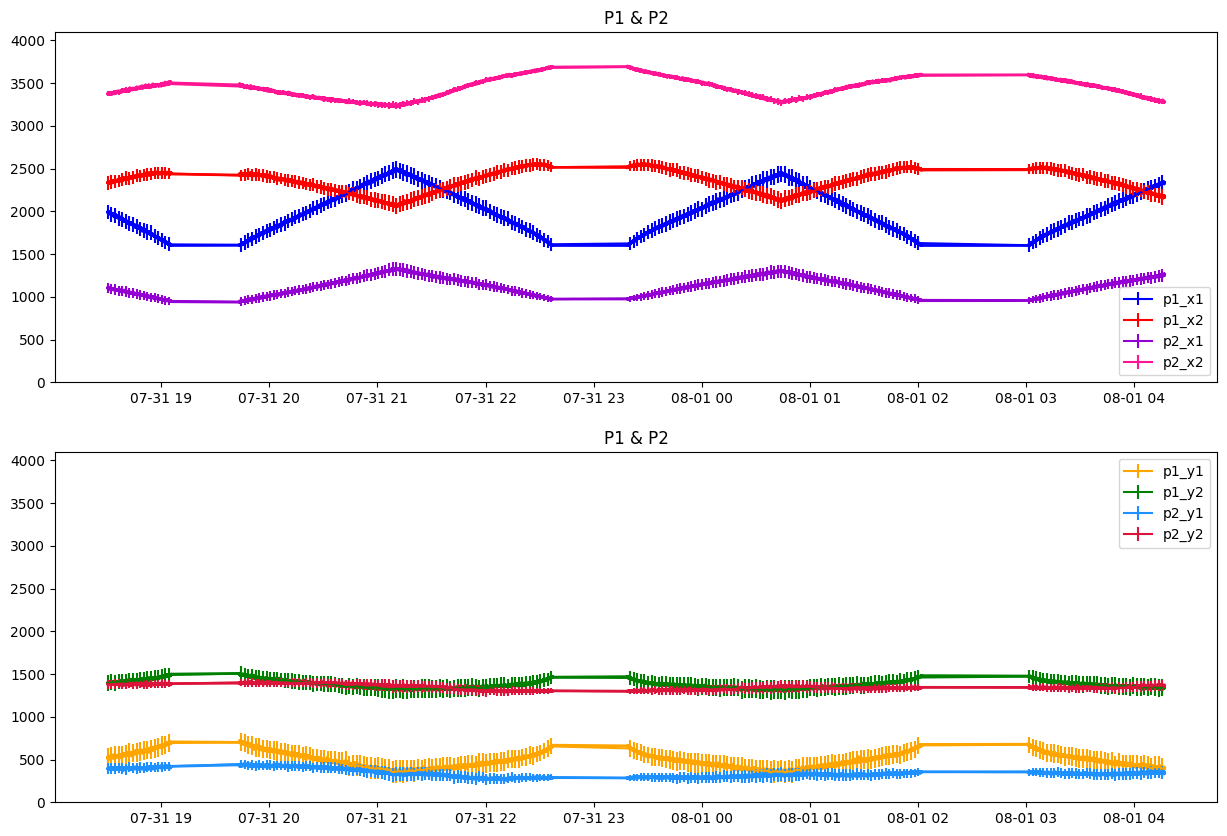

In [4]:
data = load_motor_data_file("2022-07-31_m1.txt")

data = filter_data_by_cond(data, np.asarray(data['p1_x1s']) > 1600)

plot_p1_p2(data)

In [5]:
seg = segmentate(data["x1"], 15)

seg

[(0, 0),
 (76, 2067),
 (2216, 7319),
 (7478, 12501),
 (12584, 17634),
 (17749, 22301),
 (22444, 26835)]

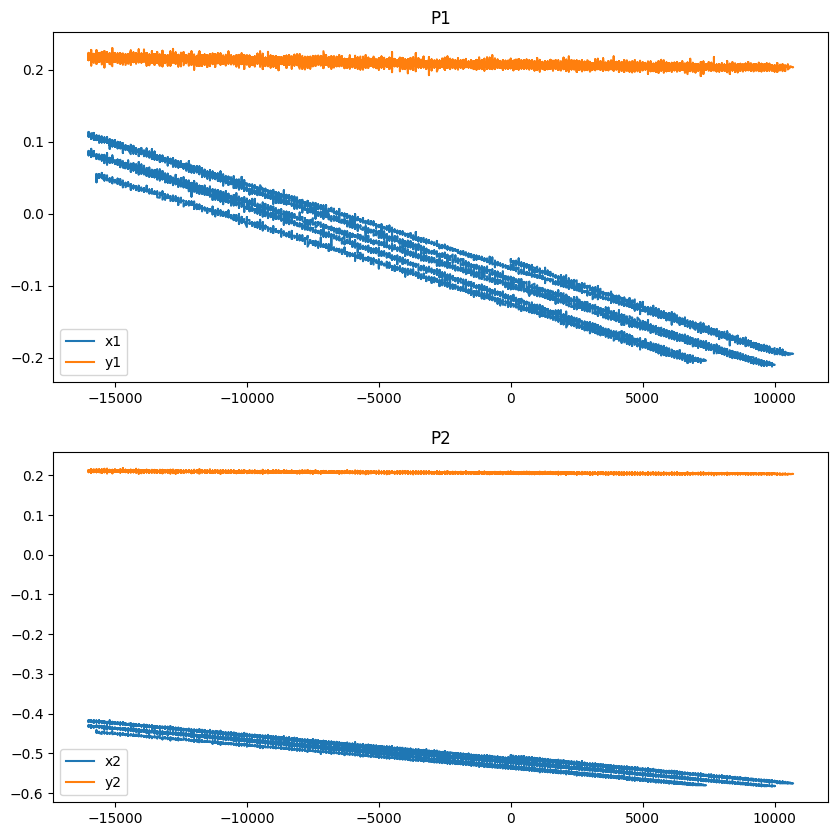

In [6]:
plot_motor(data)

seg1 kx1=-1.249e-05 ky1=-6.197e-07 kx2=-6.329e-06 ky2=-3.373e-07
seg2 kx1=-1.161e-05 ky1=-6.332e-07 kx2=-5.946e-06 ky2=-3.021e-07
seg3 kx1=-1.243e-05 ky1=-6.112e-07 kx2=-6.334e-06 ky2=-3.103e-07
seg4 kx1=-1.157e-05 ky1=-5.847e-07 kx2=-5.903e-06 ky2=-2.993e-07
seg5 kx1=-1.251e-05 ky1=-6.256e-07 kx2=-6.370e-06 ky2=-3.320e-07
seg6 kx1=-1.147e-05 ky1=-5.795e-07 kx2=-5.852e-06 ky2=-2.977e-07


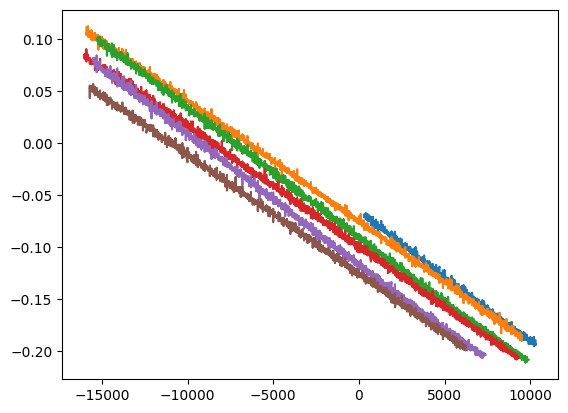

In [7]:
from scipy.stats import linregress
seg = seg[1:]
for i, (s, e) in enumerate(seg):
    plt.plot(data["motor"][s:e], data["x1"][s:e], label=f"x1_seg{i+1}")
    kx1, bx1, rx1, px1, sex1 = linregress(data["motor"][s:e], data["x1"][s:e])
    kx2, bx2, rx2, px2, sex2 = linregress(data["motor"][s:e], data["x2"][s:e])
    ky1, by1, ry1, py1, sey1 = linregress(data["motor"][s:e], data["y1"][s:e])
    ky2, by2, ry2, py2, sey2 = linregress(data["motor"][s:e], data["y2"][s:e])
    print(f"seg{i+1} kx1={kx1:.3e} ky1={ky1:.3e} kx2={kx2:.3e} ky2={ky2:.3e}")

In [8]:
m1_a_p, m1_a_n = fit_m_to_p_vector(data)

### Calibration motor M2

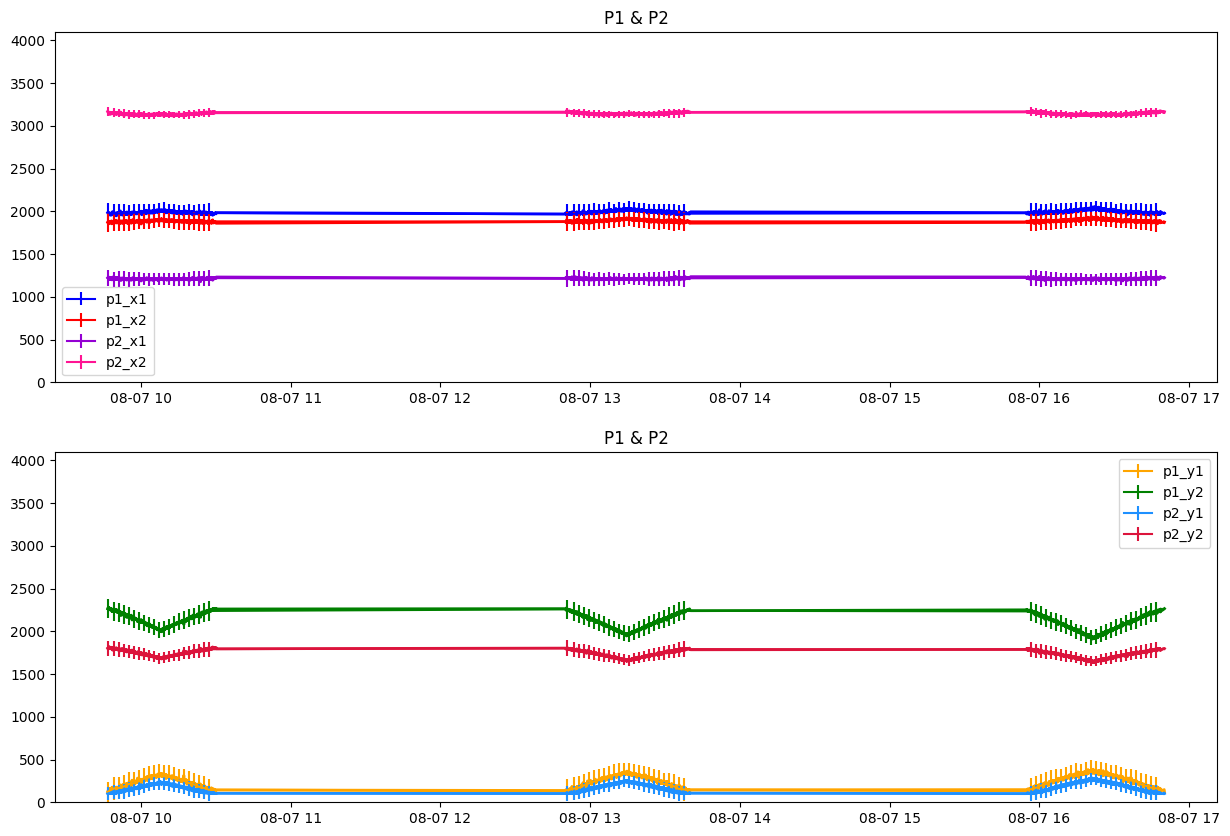

In [9]:
data = load_motor_data_file("2022-08-07_m2.txt")

data = filter_data_by_cond(data, np.asarray(data['p2_y1s']) > 100)

plot_p1_p2(data)

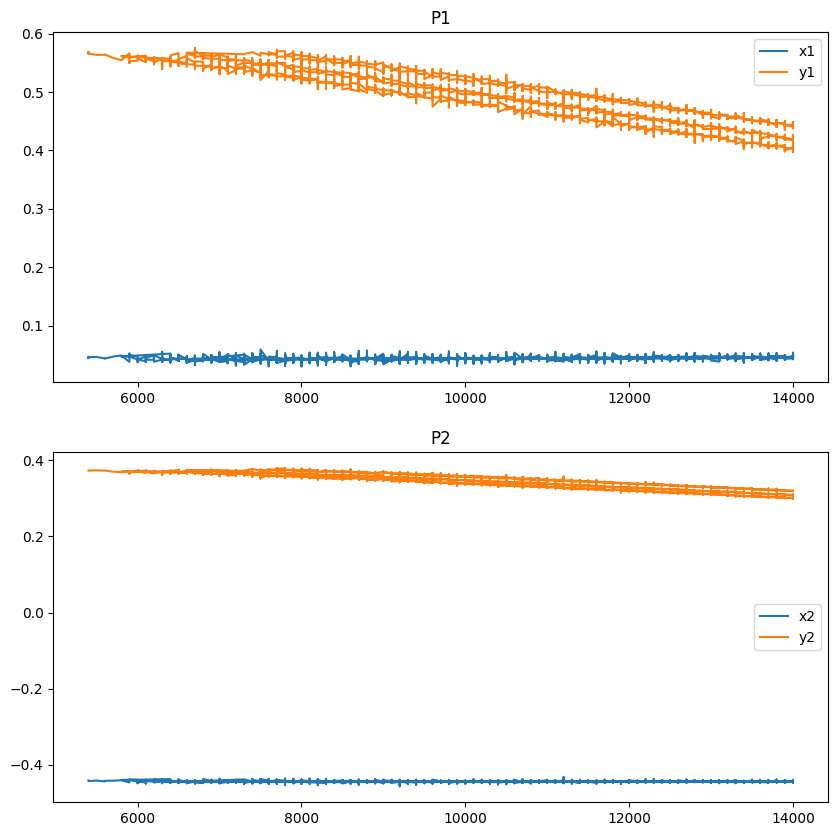

In [10]:
plot_motor(data)

In [11]:
seg = segmentate(data["y1"], 15)

seg

[(0, 0),
 (64, 1247),
 (1378, 2501),
 (2556, 3904),
 (3975, 5338),
 (5399, 6878),
 (6957, 8484)]

seg1 kx1=4.794e-07 ky1=-2.052e-05 kx2=4.160e-08 ky2=-9.330e-06
seg2 kx1=4.059e-07 ky1=-1.938e-05 kx2=5.026e-08 ky2=-8.694e-06
seg3 kx1=4.789e-07 ky1=-2.034e-05 kx2=2.225e-08 ky2=-9.302e-06
seg4 kx1=4.482e-07 ky1=-1.963e-05 kx2=7.495e-09 ky2=-8.905e-06
seg5 kx1=4.938e-07 ky1=-2.026e-05 kx2=-2.447e-08 ky2=-9.305e-06
seg6 kx1=4.712e-07 ky1=-1.967e-05 kx2=-2.792e-08 ky2=-8.944e-06


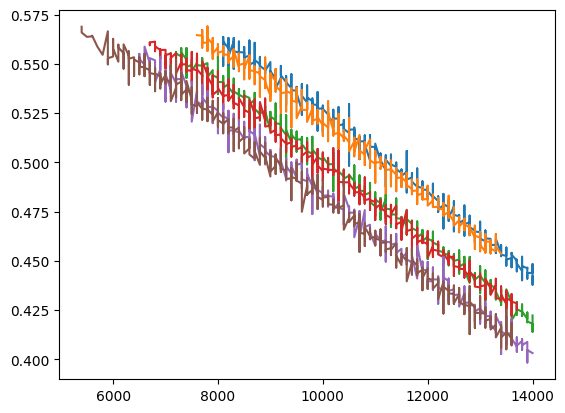

In [12]:
seg = seg[1:]
for i, (s, e) in enumerate(seg):
    plt.plot(data["motor"][s:e], data["y1"][s:e], label=f"y1_seg{i+1}")
    kx1, bx1, rx1, px1, sex1 = linregress(data["motor"][s:e], data["x1"][s:e])
    kx2, bx2, rx2, px2, sex2 = linregress(data["motor"][s:e], data["x2"][s:e])
    ky1, by1, ry1, py1, sey1 = linregress(data["motor"][s:e], data["y1"][s:e])
    ky2, by2, ry2, py2, sey2 = linregress(data["motor"][s:e], data["y2"][s:e])
    print(f"seg{i+1} kx1={kx1:.3e} ky1={ky1:.3e} kx2={kx2:.3e} ky2={ky2:.3e}")

In [13]:
m2_a_p, m2_a_n = fit_m_to_p_vector(data)

### Calibration motor M3

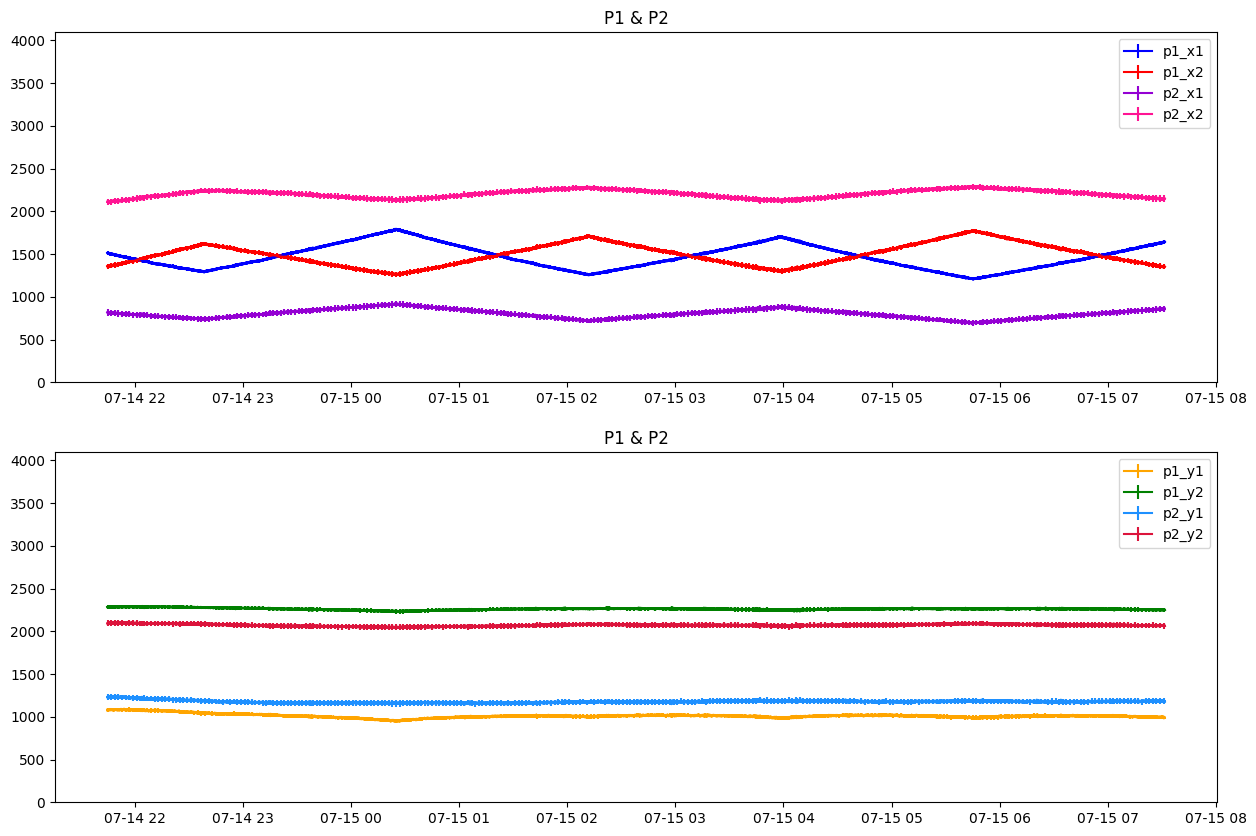

In [14]:
data = load_motor_data_file("2022-07-14_m3.txt")

plot_p1_p2(data)

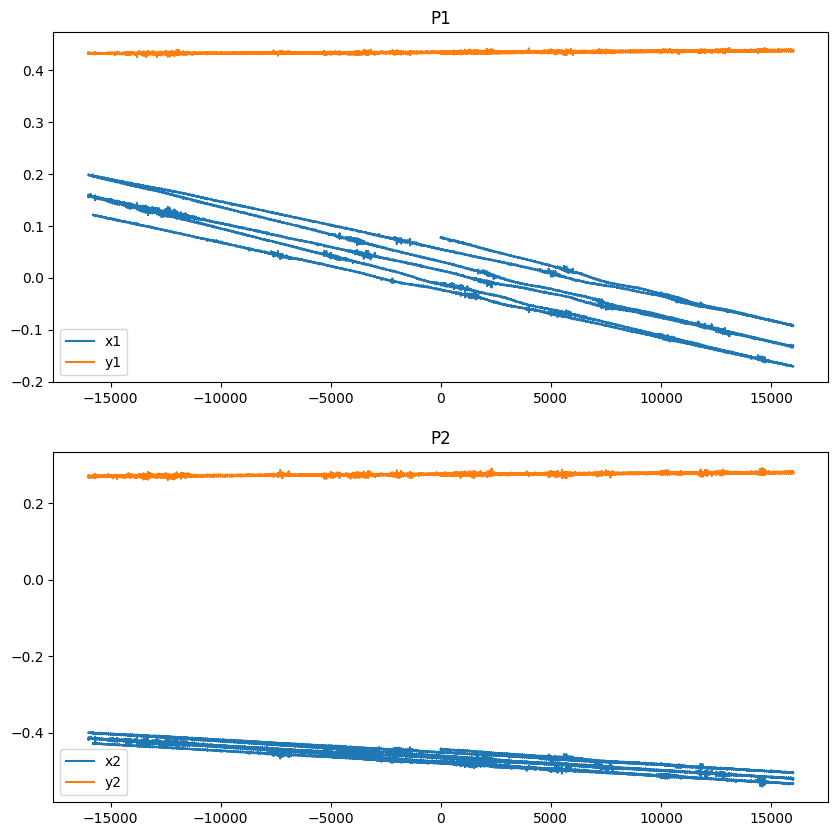

In [15]:
plot_motor(data)

In [16]:
seg = segmentate(data["x1"], 15)

seg

[(0, 0),
 (60, 3202),
 (3275, 9613),
 (9672, 16013),
 (16084, 22419),
 (22508, 28829),
 (28878, 35191)]

seg1 kx1=-1.067e-05 ky1=3.028e-07 kx2=-3.854e-06 ky2=3.941e-07
seg2 kx1=-9.163e-06 ky1=1.547e-07 kx2=-3.295e-06 ky2=3.073e-07
seg3 kx1=-1.044e-05 ky1=2.187e-07 kx2=-3.767e-06 ky2=3.600e-07
seg4 kx1=-9.103e-06 ky1=1.811e-07 kx2=-3.281e-06 ky2=3.129e-07
seg5 kx1=-1.029e-05 ky1=2.417e-07 kx2=-3.714e-06 ky2=3.546e-07
seg6 kx1=-9.182e-06 ky1=1.990e-07 kx2=-3.312e-06 ky2=3.072e-07


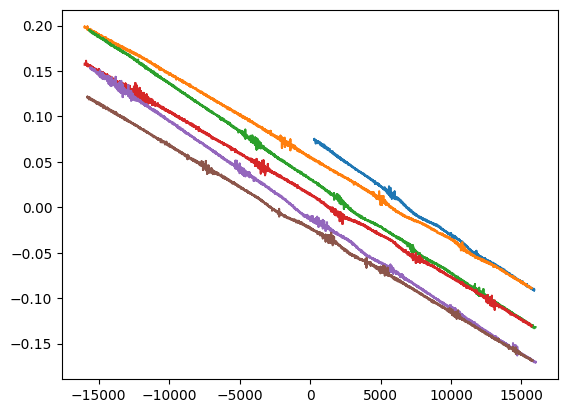

In [17]:
seg = seg[1:]
for i, (s, e) in enumerate(seg):
    plt.plot(data["motor"][s:e], data["x1"][s:e], label=f"y1_seg{i+1}")
    kx1, bx1, rx1, px1, sex1 = linregress(data["motor"][s:e], data["x1"][s:e])
    kx2, bx2, rx2, px2, sex2 = linregress(data["motor"][s:e], data["x2"][s:e])
    ky1, by1, ry1, py1, sey1 = linregress(data["motor"][s:e], data["y1"][s:e])
    ky2, by2, ry2, py2, sey2 = linregress(data["motor"][s:e], data["y2"][s:e])
    print(f"seg{i+1} kx1={kx1:.3e} ky1={ky1:.3e} kx2={kx2:.3e} ky2={ky2:.3e}")

In [18]:
m3_a_p, m3_a_n = fit_m_to_p_vector(data)

### Calibration motor M4

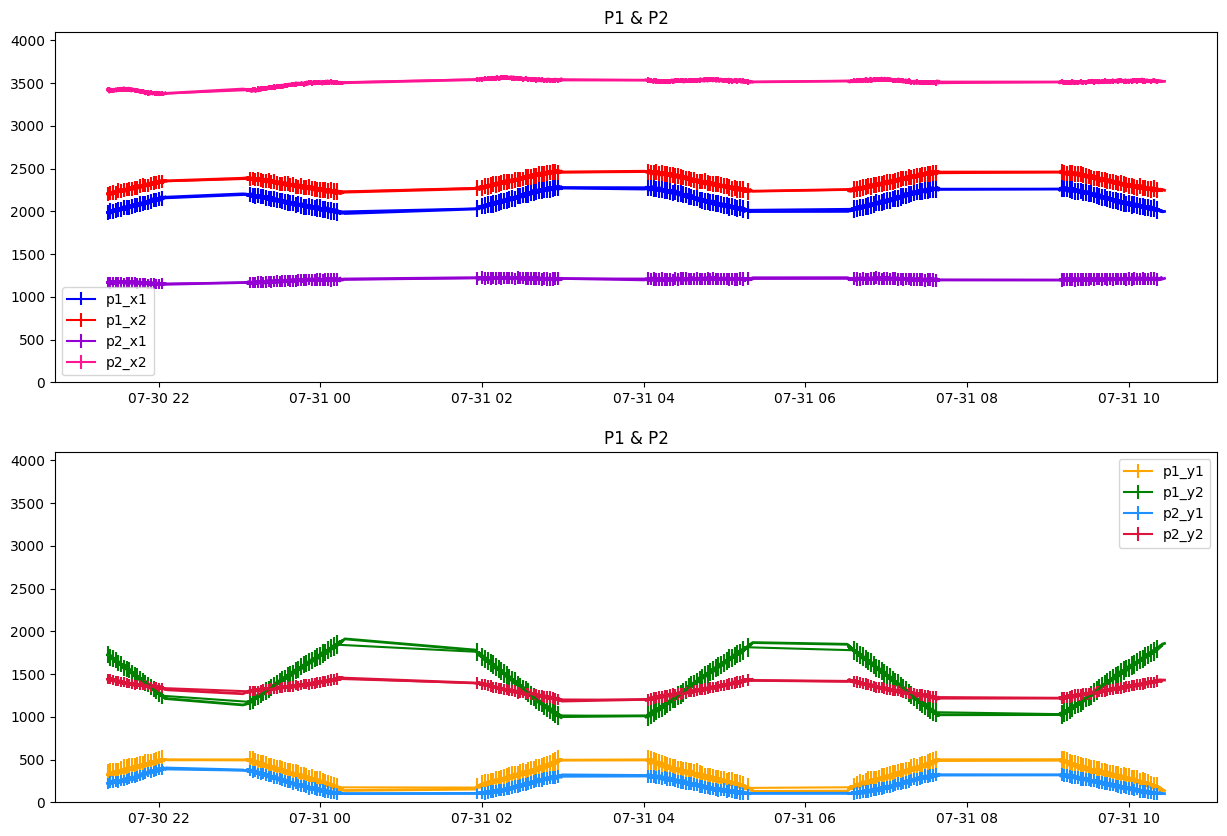

In [19]:
data = load_motor_data_file("2022-07-30_m4.txt")

data = filter_data_by_cond(data, np.asarray(data['p1_y1s']) < 500)
data = filter_data_by_cond(data, np.asarray(data['p2_y1s']) > 100)

plot_p1_p2(data)

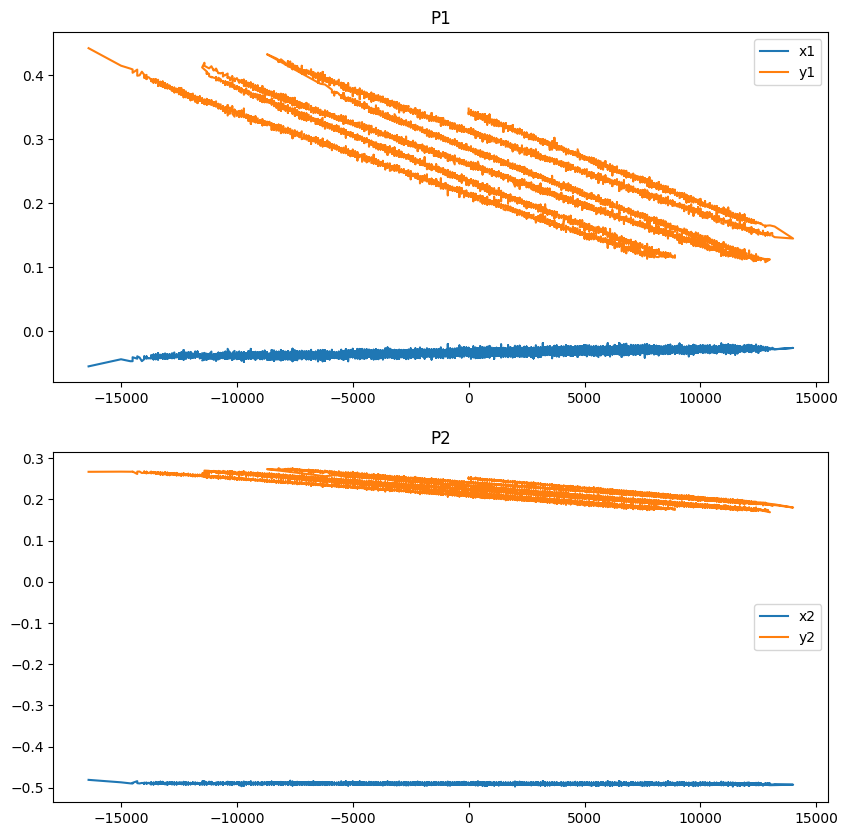

In [20]:
plot_motor(data)

In [21]:
seg = segmentate(data["y1"], 15)

seg

[(0, 0),
 (60, 2461),
 (2554, 6468),
 (6515, 10048),
 (10173, 14420),
 (14457, 18211),
 (18334, 22500)]

seg1 kx1=6.294e-07 ky1=-1.409e-05 kx2=-5.656e-08 ky2=-4.667e-06
seg2 kx1=5.897e-07 ky1=-1.286e-05 kx2=-7.850e-08 ky2=-4.168e-06
seg3 kx1=7.208e-07 ky1=-1.406e-05 kx2=-4.702e-08 ky2=-4.607e-06
seg4 kx1=6.451e-07 ky1=-1.274e-05 kx2=-4.761e-08 ky2=-4.155e-06
seg5 kx1=6.945e-07 ky1=-1.413e-05 kx2=-5.473e-08 ky2=-4.611e-06
seg6 kx1=6.392e-07 ky1=-1.271e-05 kx2=-4.523e-08 ky2=-4.135e-06


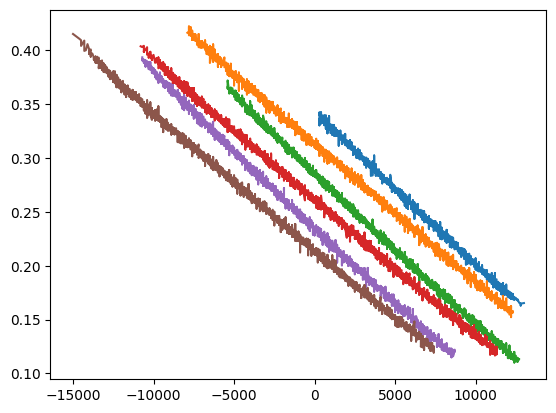

In [22]:
seg = seg[1:]
for i, (s, e) in enumerate(seg):
    plt.plot(data["motor"][s:e], data["y1"][s:e], label=f"y1_seg{i+1}")
    kx1, bx1, rx1, px1, sex1 = linregress(data["motor"][s:e], data["x1"][s:e])
    kx2, bx2, rx2, px2, sex2 = linregress(data["motor"][s:e], data["x2"][s:e])
    ky1, by1, ry1, py1, sey1 = linregress(data["motor"][s:e], data["y1"][s:e])
    ky2, by2, ry2, py2, sey2 = linregress(data["motor"][s:e], data["y2"][s:e])
    print(f"seg{i+1} kx1={kx1:.3e} ky1={ky1:.3e} kx2={kx2:.3e} ky2={ky2:.3e}")

In [23]:
m4_a_p, m4_a_n = fit_m_to_p_vector(data)

### Analyzing fitting errors

In [24]:
import statsmodels.api as sm

ms = data["motor"][seg[0][0]: seg[0][1]]
ys = data["x1"][seg[0][0]: seg[0][1]]
y_errs = data["err_x1"][seg[0][0]: seg[0][1]]
y_errs[y_errs < 1e-9] = 0.001

ms = sm.add_constant(ms)

mod_wls = sm.WLS(ys, ms, 1/y_errs**2)
res_wls = mod_wls.fit()

print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.656
Model:                            WLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     4577.
Date:                Wed, 17 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:50:54   Log-Likelihood:                 12076.
No. Observations:                2401   AIC:                        -2.415e+04
Df Residuals:                    2399   BIC:                        -2.414e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0377   6.92e-05   -544.559      0.0

In [25]:
mod_ols = sm.OLS(ys, ms)
res_ols = mod_ols.fit()

print(res_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     4547.
Date:                Wed, 17 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:50:55   Log-Likelihood:                 12071.
No. Observations:                2401   AIC:                        -2.414e+04
Df Residuals:                    2399   BIC:                        -2.413e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0377   6.67e-05   -564.911      0.0

## Construct M-Matrix (inversed A-matrix) from p-vectors

In [26]:
# Column vectors of A

m1_a_p_col = np.array([m1_a_p["x1"], m1_a_p["y1"], m1_a_p["x2"], m1_a_p["y2"]])
m2_a_p_col = np.array([m2_a_p["x1"], m2_a_p["y1"], m2_a_p["x2"], m2_a_p["y2"]])
m3_a_p_col = np.array([m3_a_p["x1"], m3_a_p["y1"], m3_a_p["x2"], m3_a_p["y2"]])
m4_a_p_col = np.array([m4_a_p["x1"], m4_a_p["y1"], m4_a_p["x2"], m4_a_p["y2"]])

m1_a_n_col = np.array([m1_a_n["x1"], m1_a_n["y1"], m1_a_n["x2"], m1_a_n["y2"]])
m2_a_n_col = np.array([m2_a_n["x1"], m2_a_n["y1"], m2_a_n["x2"], m2_a_n["y2"]])
m3_a_n_col = np.array([m3_a_n["x1"], m3_a_n["y1"], m3_a_n["x2"], m3_a_n["y2"]])
m4_a_n_col = np.array([m4_a_n["x1"], m4_a_n["y1"], m4_a_n["x2"], m4_a_n["y2"]])


# filtering
# m1_a_p_col[abs(m1_a_p_col) < 1e-6] = 0
# m2_a_p_col[abs(m2_a_p_col) < 1e-6] = 0
# m3_a_p_col[abs(m3_a_p_col) < 1e-6] = 0
# m4_a_p_col[abs(m4_a_p_col) < 1e-6] = 0
# m1_a_n_col[abs(m1_a_n_col) < 1e-6] = 0
# m2_a_n_col[abs(m2_a_n_col) < 1e-6] = 0
# m3_a_n_col[abs(m3_a_n_col) < 1e-6] = 0
# m4_a_n_col[abs(m4_a_n_col) < 1e-6] = 0


# 16 matrices

Mpppp = np.array([m1_a_p_col, m2_a_p_col, m3_a_p_col, m4_a_p_col]).transpose()
Mpppn = np.array([m1_a_p_col, m2_a_p_col, m3_a_p_col, m4_a_n_col]).transpose()
Mppnp = np.array([m1_a_p_col, m2_a_p_col, m3_a_n_col, m4_a_p_col]).transpose()
Mpnpp = np.array([m1_a_p_col, m2_a_n_col, m3_a_p_col, m4_a_p_col]).transpose()
Mnppp = np.array([m1_a_n_col, m2_a_p_col, m3_a_p_col, m4_a_p_col]).transpose()
Mppnn = np.array([m1_a_p_col, m2_a_p_col, m3_a_n_col, m4_a_n_col]).transpose()
Mpnpn = np.array([m1_a_p_col, m2_a_n_col, m3_a_p_col, m4_a_n_col]).transpose()
Mpnnp = np.array([m1_a_p_col, m2_a_n_col, m3_a_n_col, m4_a_p_col]).transpose()
Mnppn = np.array([m1_a_n_col, m2_a_p_col, m3_a_p_col, m4_a_n_col]).transpose()
Mnpnp = np.array([m1_a_n_col, m2_a_p_col, m3_a_n_col, m4_a_p_col]).transpose()
Mnnpp = np.array([m1_a_n_col, m2_a_n_col, m3_a_p_col, m4_a_p_col]).transpose()
Mnnnp = np.array([m1_a_n_col, m2_a_n_col, m3_a_n_col, m4_a_p_col]).transpose()
Mnnpn = np.array([m1_a_n_col, m2_a_n_col, m3_a_p_col, m4_a_n_col]).transpose()
Mnpnn = np.array([m1_a_n_col, m2_a_p_col, m3_a_n_col, m4_a_n_col]).transpose()
Mpnnn = np.array([m1_a_p_col, m2_a_n_col, m3_a_n_col, m4_a_n_col]).transpose()
Mnnnn = np.array([m1_a_n_col, m2_a_n_col, m3_a_n_col, m4_a_n_col]).transpose()

In [27]:
Mpppp

array([[-1.24795836e-05,  4.84067060e-07, -1.04675905e-05,
         6.81566042e-07],
       [-6.18843005e-07, -2.03725171e-05,  2.54387555e-07,
        -1.40951818e-05],
       [-6.34461814e-06,  1.31252801e-08, -3.77853698e-06,
        -5.27683524e-08],
       [-3.26505038e-07, -9.31254890e-06,  3.69581025e-07,
        -4.62812284e-06]])

In [28]:
from numpy.linalg import inv

Apppp = inv(Mpppp)
Apppn = inv(Mpppn)
Appnp = inv(Mppnp)
Apnpp = inv(Mpnpp)
Anppp = inv(Mnppp)
Appnn = inv(Mppnn)
Apnpn = inv(Mpnpn)
Apnnp = inv(Mpnnp)
Anppn = inv(Mnppn)
Anpnp = inv(Mnpnp)
Annpp = inv(Mnnpp)
Annnp = inv(Mnnnp)
Annpn = inv(Mnnpn)
Anpnn = inv(Mnpnn)
Apnnn = inv(Mpnnn)
Annnn = inv(Mnnnn)

In [29]:
Apppp

array([[ 192015.84490119,   29320.89300547, -535334.3620723 ,
         -54917.10885759],
       [ -44276.18557879,  118838.04783329,   94514.4558715 ,
        -369525.28372418],
       [-323265.99746031,  -45401.58150728,  635985.62852174,
          83415.35404189],
       [  49730.10265187, -244815.91188302, -101624.98310346,
         538011.15572848]])

### Verification of the calbration

Try to use the fit to reproduce the original data.

In [32]:
def m_matrix_select(m_vec):
    cand = np.array([Mpppp, Mpppn, Mppnp, Mppnn, Mpnpp, Mpnpn, Mpnnp, Mpnnn,
                     Mnppp, Mnppn, Mnpnp, Mnpnn, Mnnpp, Mnnpn, Mnnnp, Mnnnn])
    s = np.array((m_vec < 0), dtype=int)
    return cand[s[3] + (s[2] << 1) + (s[1] << 2) + (s[0] << 3)]

def a_matrix_select(m_vec):
    cand = np.array([Apppp, Apppn, Appnp, Appnn, Apnpp, Apnpn, Apnnp, Apnnn,
                     Anppp, Anppn, Anpnp, Anpnn, Annpp, Annpn, Annnp, Annnn])
    s = np.array((m_vec < 0), dtype=int)
    return cand[s[3] + (s[2] << 1) + (s[1] << 2) + (s[0] << 3)]

### Use the fit to reproduce independently-measured new data


| m1   | m2   | m3   | m4   | x1   | y1   | x2    | y2   |
|------|------|------|------|------|------|-------|------|
| 0    | 0    | 0    | 0    | 0.13 | 0.28 | -0.23 | 0.28 |
| 0    | 5000 | 0    | 0    | 0.14 | 0.19 | -0.23 | 0.23 |
| 5000 | 5000 | 0    | 0    | 0.08 | 0.19 | -0.26 | 0.23 |
| 5000 | 5000 | 5000 | 0    | 0.04 | 0.19 | -0.28 | 0.23 |
| 5000 | 5000 | 5000 | 5000 | 0.04 | 0.13 | -0.28 | 0.21 |
| 0    | 5000 | 5000 | 5000 | 0.09 | 0.13 | -0.25 | 0.21 |
| 0    | 0    | 5000 | 5000 | 0.09 | 0.21 | -0.25 | 0.25 |
| 0    | 0    | 0    | 5000 | 0.13 | 0.21 | -0.24 | 0.25 |
| 0    | 0    | 0    | 0    | 0.12 | 0.27 | -0.24 | 0.27 |

- `m1`: Commanded motor steps
- `x1`: Measured beam position
- `x1_c`: Calculated beam position from the fit
- `ex1`: Error between the measurament and the fit

See the table under the next cell.

In [33]:
table = """ 0    | 0    | 0    | 0    | 0.13 | 0.28 | -0.23 | 0.28
0    | 5000 | 0    | 0    | 0.14 | 0.19 | -0.23 | 0.23
5000 | 5000 | 0    | 0    | 0.08 | 0.19 | -0.26 | 0.23
5000 | 5000 | 5000 | 0    | 0.04 | 0.19 | -0.28 | 0.23
5000 | 5000 | 5000 | 5000 | 0.04 | 0.13 | -0.28 | 0.21
0    | 5000 | 5000 | 5000 | 0.09 | 0.13 | -0.25 | 0.21
0    | 0    | 5000 | 5000 | 0.09 | 0.21 | -0.25 | 0.25
0    | 0    | 0    | 5000 | 0.13 | 0.21 | -0.24 | 0.25
0    | 0    | 0    | 0    | 0.12 | 0.27 | -0.24 | 0.27"""

m1_rs, m2_rs, m3_rs, m4_rs, x1_rs, y1_rs, x2_rs, y2_rs = [], [] ,[], [], [], [], [], []
for line in table.split("\n"):
    [arr.append(float(val)) for val, arr in zip(line.split("|"), [m1_rs, m2_rs, m3_rs, m4_rs, x1_rs, y1_rs, x2_rs, y2_rs])]

x1_cs, y1_cs, x2_cs, y2_cs = [], [] ,[], []
x1_cs.append(x1_rs[0])
y1_cs.append(y1_rs[0])
x2_cs.append(x2_rs[0])
y2_cs.append(y2_rs[0])

for i in range(1, len(m1_rs)):
    _delta_m_vec = np.array([m1_rs[i] - m1_rs[i-1],  m2_rs[i] - m2_rs[i-1], m3_rs[i] - m3_rs[i-1], m4_rs[i] - m4_rs[i-1]])
    _delta_x_vec_cal = m_matrix_select(_delta_m_vec) @ _delta_m_vec 
    
    _x_vec = np.array([x1_cs[i-1], y1_cs[i-1], x2_cs[i-1], y2_cs[i-1]]) + _delta_x_vec_cal
    
    [arr.append(float(val)) for val, arr in zip(_x_vec, [x1_cs, y1_cs, x2_cs, y2_cs])]

x1_diffs, y1_diffs, x2_diffs, y2_diffs = np.asarray(x1_cs) - np.asarray(x1_rs), np.asarray(y1_cs) - np.asarray(y1_rs), np.asarray(x2_cs) - np.asarray(x2_rs), np.asarray(y2_cs) - np.asarray(y2_rs) 

table = """| m1   | m2   | m3   | m4   | x1   | y1   | x2    | y2   | x1_c   | y1_c   | x2_c    | y2_c   | ϵx1   | ϵy1   | ϵx2    | ϵy2   |
|------|------|------|------|------|------|-------|------|------|------|-------|------|------|------|-------|------|
"""
for arr in zip(m1_rs, m2_rs, m3_rs, m4_rs, x1_rs, y1_rs, x2_rs, y2_rs, x1_cs, y1_cs, x2_cs, y2_cs, x1_diffs, y1_diffs, x2_diffs, y2_diffs):
    table += " | ".join([f"{a:.2f}" for a in arr])
    table += "|\n"

from IPython.display import display, Markdown
display(Markdown(table))

| m1   | m2   | m3   | m4   | x1   | y1   | x2    | y2   | x1_c   | y1_c   | x2_c    | y2_c   | ϵx1   | ϵy1   | ϵx2    | ϵy2   |
|------|------|------|------|------|------|-------|------|------|------|-------|------|------|------|-------|------|
0.00 | 0.00 | 0.00 | 0.00 | 0.13 | 0.28 | -0.23 | 0.28 | 0.13 | 0.28 | -0.23 | 0.28 | 0.00 | 0.00 | 0.00 | 0.00|
0.00 | 5000.00 | 0.00 | 0.00 | 0.14 | 0.19 | -0.23 | 0.23 | 0.13 | 0.18 | -0.23 | 0.23 | -0.01 | -0.01 | 0.00 | 0.00|
5000.00 | 5000.00 | 0.00 | 0.00 | 0.08 | 0.19 | -0.26 | 0.23 | 0.07 | 0.18 | -0.26 | 0.23 | -0.01 | -0.01 | -0.00 | 0.00|
5000.00 | 5000.00 | 5000.00 | 0.00 | 0.04 | 0.19 | -0.28 | 0.23 | 0.02 | 0.18 | -0.28 | 0.23 | -0.02 | -0.01 | -0.00 | 0.00|
5000.00 | 5000.00 | 5000.00 | 5000.00 | 0.04 | 0.13 | -0.28 | 0.21 | 0.02 | 0.11 | -0.28 | 0.21 | -0.02 | -0.02 | -0.00 | 0.00|
0.00 | 5000.00 | 5000.00 | 5000.00 | 0.09 | 0.13 | -0.25 | 0.21 | 0.08 | 0.11 | -0.25 | 0.21 | -0.01 | -0.02 | -0.00 | 0.00|
0.00 | 0.00 | 5000.00 | 5000.00 | 0.09 | 0.21 | -0.25 | 0.25 | 0.08 | 0.21 | -0.25 | 0.26 | -0.01 | -0.00 | -0.00 | 0.01|
0.00 | 0.00 | 0.00 | 5000.00 | 0.13 | 0.21 | -0.24 | 0.25 | 0.12 | 0.21 | -0.23 | 0.25 | -0.01 | -0.00 | 0.01 | 0.00|
0.00 | 0.00 | 0.00 | 0.00 | 0.12 | 0.27 | -0.24 | 0.27 | 0.12 | 0.27 | -0.23 | 0.28 | -0.00 | -0.00 | 0.01 | 0.01|


## Code generation

The below cells generate the part of the `BeamPositionMatrix.h`.

In [34]:
combs = [
    ('P', 'P', 'P', 'P', Apppp),
    ('P', 'P', 'P', 'N', Apppn),
    ('P', 'P', 'N', 'P', Appnp),
    ('P', 'P', 'N', 'N', Appnn),
    ('P', 'N', 'P', 'P', Apnpp),
    ('P', 'N', 'P', 'N', Apnpn),
    ('P', 'N', 'N', 'P', Apnnp),
    ('P', 'N', 'N', 'N', Apnnn),
    ('N', 'P', 'P', 'P', Anppp),
    ('N', 'P', 'P', 'N', Anppn),
    ('N', 'P', 'N', 'P', Anpnp),
    ('N', 'P', 'N', 'N', Anpnn),
    ('N', 'N', 'P', 'P', Annpp),
    ('N', 'N', 'P', 'N', Annpn),
    ('N', 'N', 'N', 'P', Annnp),
    ('N', 'N', 'N', 'N', Annnn)
]

code = ""
for m1dir, m2dir, m3dir, m4dir, b in combs:
    code += f"""const PositionMotionMatrix POS_MTR_MTX_{m1dir}_{m2dir}_{m3dir}_{m4dir} = {{
    {{
        {{ {int(b[0][0]):>7d}, {int(b[0][1]):>7d}, {int(b[0][2]):>7d}, {int(b[0][3]):>7d} }},
        {{ {int(b[1][0]):>7d}, {int(b[1][1]):>7d}, {int(b[1][2]):>7d}, {int(b[1][3]):>7d} }},
        {{ {int(b[2][0]):>7d}, {int(b[2][1]):>7d}, {int(b[2][2]):>7d}, {int(b[2][3]):>7d} }},
        {{ {int(b[3][0]):>7d}, {int(b[3][1]):>7d}, {int(b[3][2]):>7d}, {int(b[3][3]):>7d} }},
    }}
}};
    
"""

In [35]:
for m1dir, m2dir, m3dir, m4dir, b in combs:
    code += f"POS_MTR_MTX_{m1dir}_{m2dir}_{m3dir}_{m4dir}, "
print(code)

const PositionMotionMatrix POS_MTR_MTX_P_P_P_P = {
    {
        {  192015,   29320, -535334,  -54917 },
        {  -44276,  118838,   94514, -369525 },
        { -323265,  -45401,  635985,   83415 },
        {   49730, -244815, -101624,  538011 },
    }
};
    
const PositionMotionMatrix POS_MTR_MTX_P_P_P_N = {
    {
        {  191791,   30424, -534876,  -57343 },
        {  -43422,  114637,   92770, -360294 },
        { -323001,  -46704,  635444,   86277 },
        {   53552, -263632, -109436,  579363 },
    }
};
    
const PositionMotionMatrix POS_MTR_MTX_P_P_N_P = {
    {
        {  190488,   29106, -532329,  -54522 },
        {  -44078,  118865,   94125, -369576 },
        { -367675,  -51638,  723355,   94874 },
        {   50694, -244680, -103522,  537762 },
    }
};
    
const PositionMotionMatrix POS_MTR_MTX_P_P_N_N = {
    {
        {  190260,   30203, -531864,  -56934 },
        {  -43208,  114668,   92349, -360351 },
        { -367368,  -53119,  722728,   98128 },
        { 

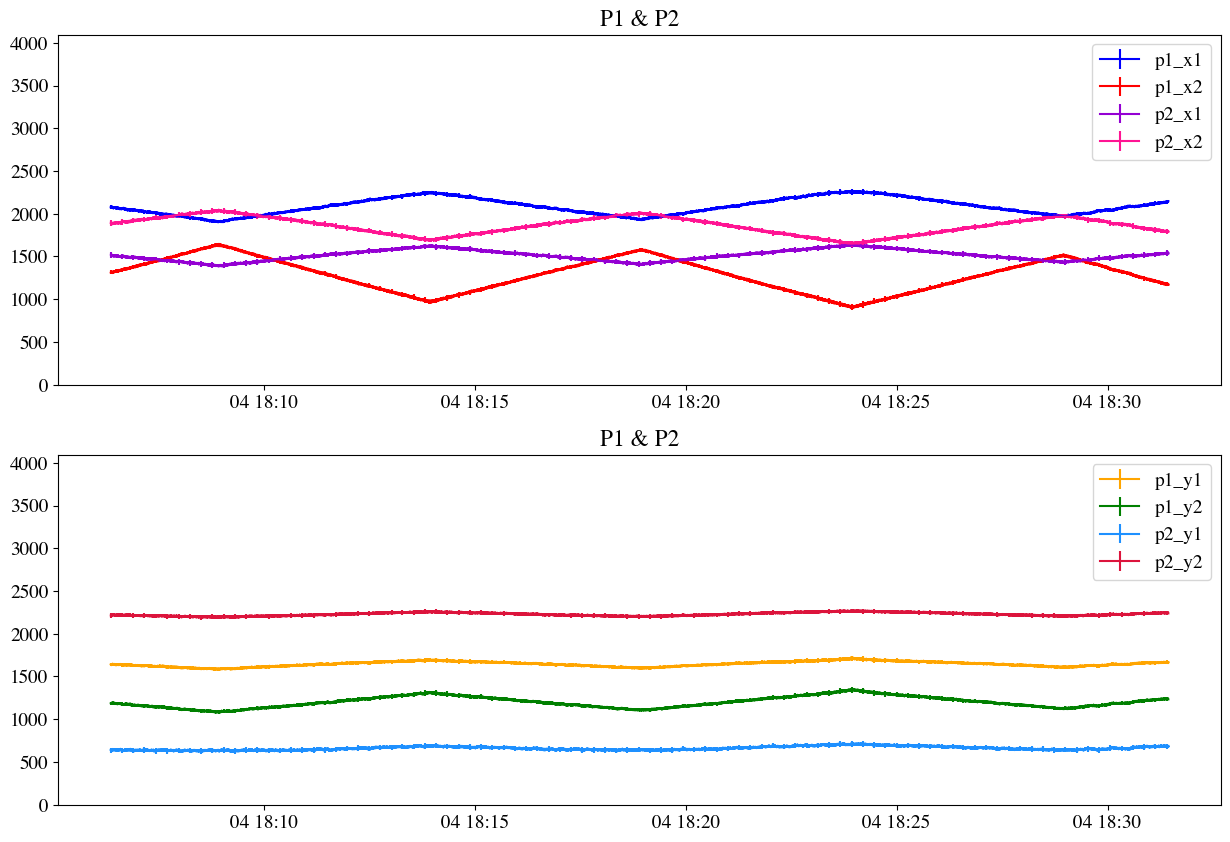

In [65]:
data_seg = []
for i in range(6):
    data = load_motor_data_file(f"2022-09-04T18_m1_seg{i}.txt")
    data_seg.append(data)

data = merge_seg_dict(data_seg)
plot_p1_p2(data)

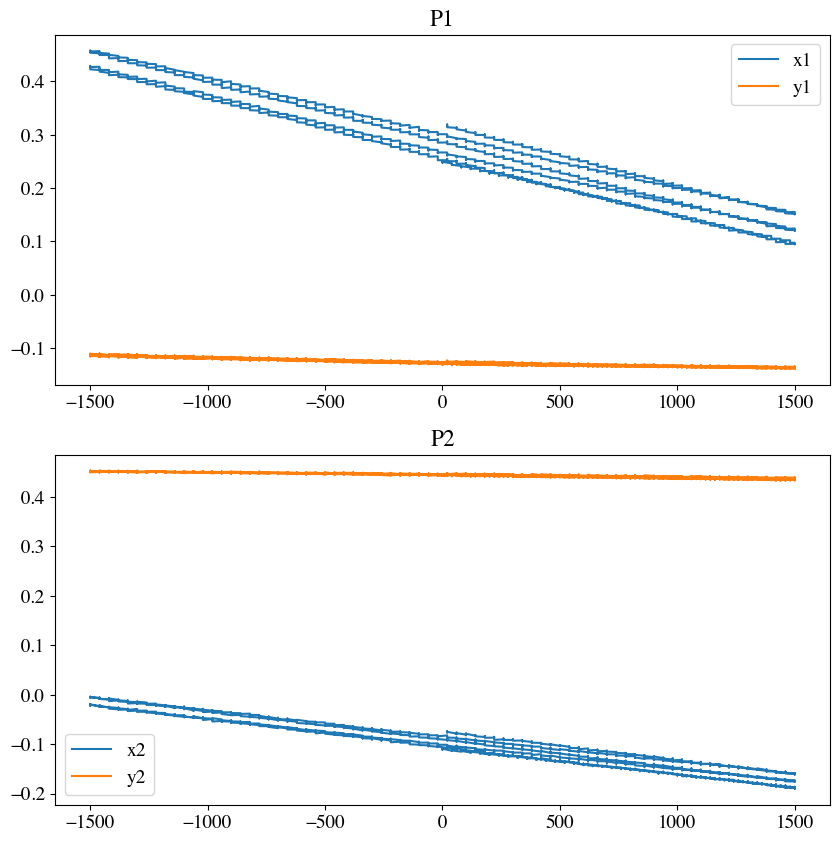

In [66]:
plot_motor(data)

In [114]:
m1_a_p, m1_a_n = fit_seg_m_to_p_vector(data_seg)

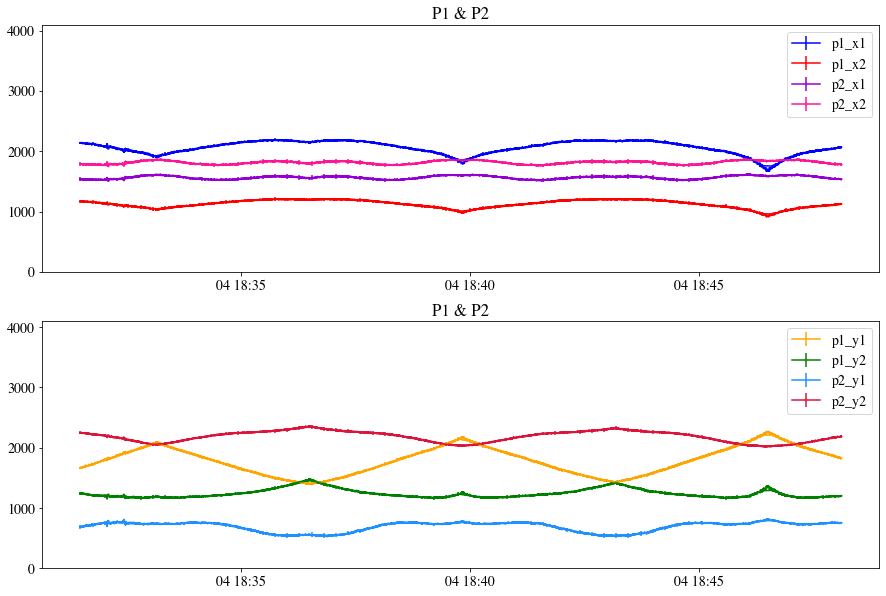

In [264]:
data_seg = []
for i in range(6):
    data = load_motor_data_file(f"2022-09-04T18_m2_seg{i}.txt")
    data_seg.append(data)

data = merge_seg_dict(data_seg)
plot_p1_p2(data)

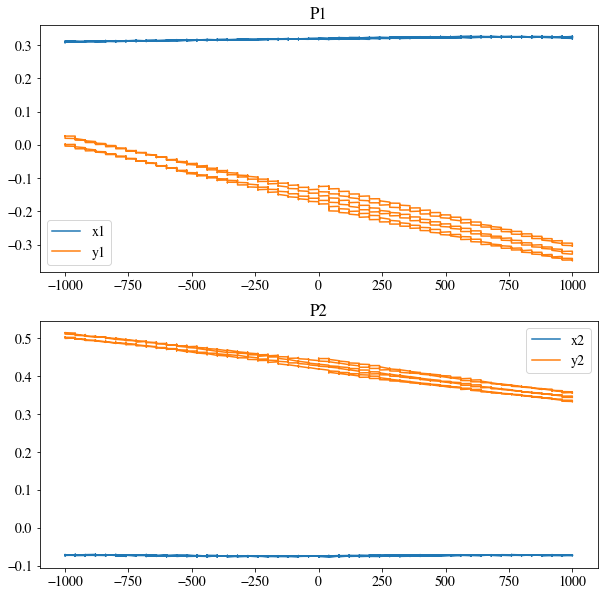

In [265]:
plot_motor(data)

0.002282589358229642

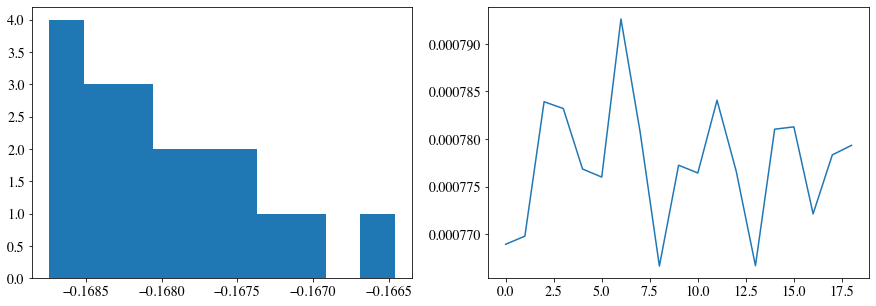

In [268]:
y1_cut = np.asarray(data["y1"])[np.equal(data["motor"], 240)][1:20]
err_y1_cut = np.asarray(data["err_y1"])[np.equal(data["motor"], 240)][1:20]/np.sqrt(200)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(y1_cut)
plt.subplot(122)
plt.plot(err_y1_cut)
max(y1_cut) - min(y1_cut)

In [278]:
np.sqrt(np.average(np.asarray(data["p1_err_y1s"])[np.equal(data["motor"], 240)][1:20]))/4096*3.3

0.01855790720555521

In [279]:
np.sqrt(np.average(np.asarray(data["p1_err_y2s"])[np.equal(data["motor"], 240)][1:20]))/4096*3.3

0.021072470656346175

0.0016193740167481652

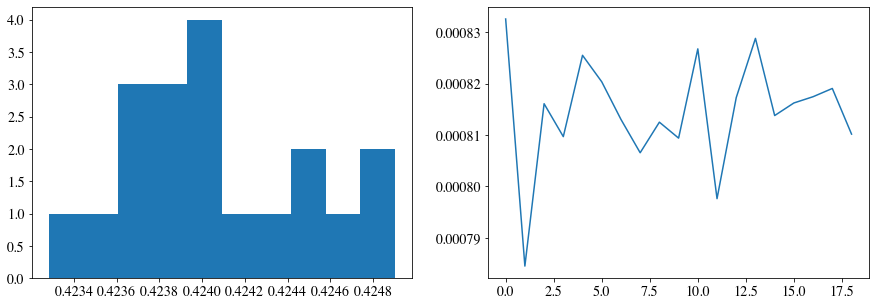

In [269]:
y2_cut = np.asarray(data["y2"])[np.equal(data["motor"], 240)][1:20]
err_y2_cut = np.asarray(data["err_y2"])[np.equal(data["motor"], 240)][1:20]/np.sqrt(200)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(y2_cut)
plt.subplot(122)
plt.plot(err_y2_cut)
max(y2_cut) - min(y2_cut)

In [280]:
import statsmodels.api as sm

ms = data_seg[0]["motor"]
ys = data_seg[0]["y1"]
y_errs = data_seg[0]["err_y1"]
y_errs[y_errs < 1e-9] = 0.001

ms = sm.add_constant(ms)

mod_wls = sm.WLS(ys, ms, 1/y_errs**2)
res_wls = mod_wls.fit()

print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            WLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.516e+05
Date:                Mon, 10 Oct 2022   Prob (F-statistic):               0.00
Time:                        13:45:24   Log-Likelihood:                 3777.4
No. Observations:                 752   AIC:                            -7551.
Df Residuals:                     750   BIC:                            -7542.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1247      0.000  -1180.649      0.0

In [282]:
res_wls.rsquared

0.9990031725979607

In [117]:
m2_a_p, m2_a_n = fit_seg_m_to_p_vector(data_seg)

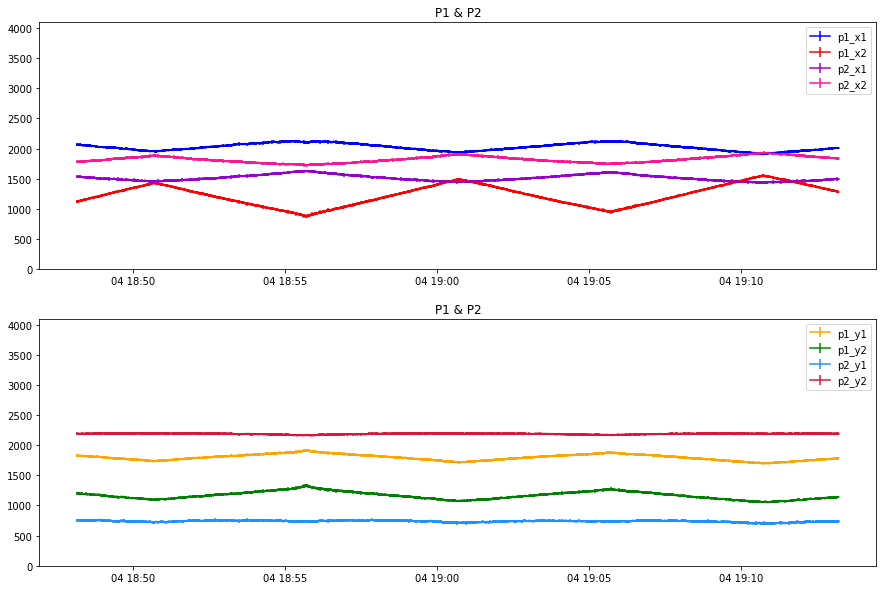

In [118]:
data_seg = []
for i in range(6):
    data = load_motor_data_file(f"2022-09-04T18_m3_seg{i}.txt")
    data_seg.append(data)

data = merge_seg_dict(data_seg)
plot_p1_p2(data)

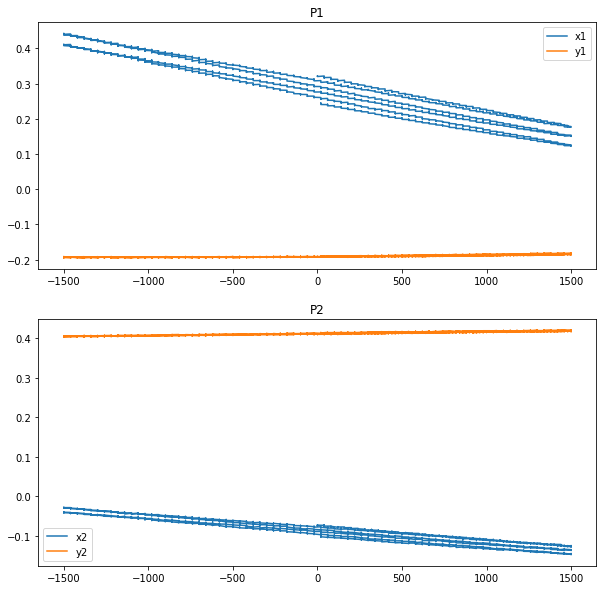

In [119]:
plot_motor(data)

In [120]:
m3_a_p, m3_a_n = fit_seg_m_to_p_vector(data_seg)

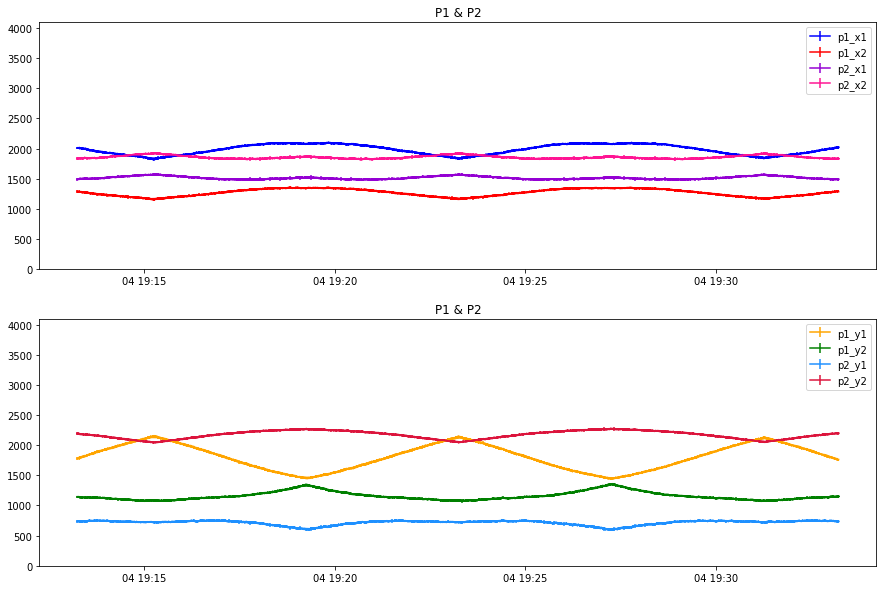

In [121]:
data_seg = []
for i in range(6):
    data = load_motor_data_file(f"2022-09-04T18_m4_seg{i}.txt")
    data_seg.append(data)

data = merge_seg_dict(data_seg)
plot_p1_p2(data)

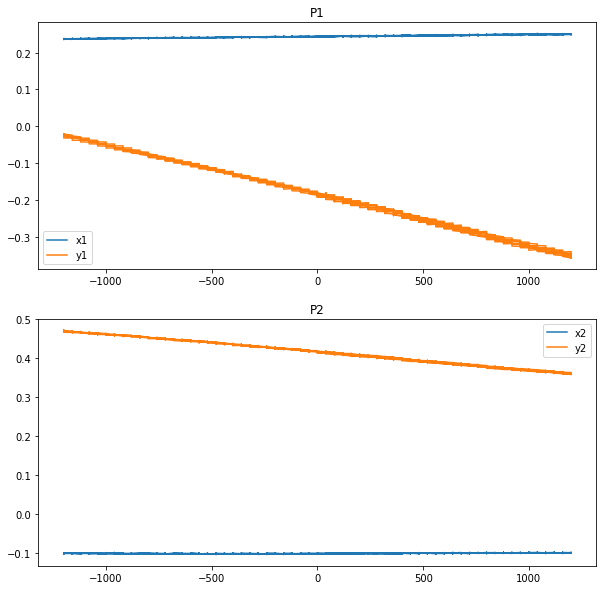

In [122]:
plot_motor(data)

In [123]:
m4_a_p, m4_a_n = fit_seg_m_to_p_vector(data_seg)

In [124]:
from numpy.linalg import inv

# Column vectors of A

m1_a_p_col = np.array([m1_a_p["x1"], m1_a_p["y1"], m1_a_p["x2"], m1_a_p["y2"]])
m2_a_p_col = np.array([m2_a_p["x1"], m2_a_p["y1"], m2_a_p["x2"], m2_a_p["y2"]])
m3_a_p_col = np.array([m3_a_p["x1"], m3_a_p["y1"], m3_a_p["x2"], m3_a_p["y2"]])
m4_a_p_col = np.array([m4_a_p["x1"], m4_a_p["y1"], m4_a_p["x2"], m4_a_p["y2"]])

m1_a_n_col = np.array([m1_a_n["x1"], m1_a_n["y1"], m1_a_n["x2"], m1_a_n["y2"]])
m2_a_n_col = np.array([m2_a_n["x1"], m2_a_n["y1"], m2_a_n["x2"], m2_a_n["y2"]])
m3_a_n_col = np.array([m3_a_n["x1"], m3_a_n["y1"], m3_a_n["x2"], m3_a_n["y2"]])
m4_a_n_col = np.array([m4_a_n["x1"], m4_a_n["y1"], m4_a_n["x2"], m4_a_n["y2"]])


# filtering
# m1_a_p_col[abs(m1_a_p_col) < 1e-6] = 0
# m2_a_p_col[abs(m2_a_p_col) < 1e-6] = 0
# m3_a_p_col[abs(m3_a_p_col) < 1e-6] = 0
# m4_a_p_col[abs(m4_a_p_col) < 1e-6] = 0
# m1_a_n_col[abs(m1_a_n_col) < 1e-6] = 0
# m2_a_n_col[abs(m2_a_n_col) < 1e-6] = 0
# m3_a_n_col[abs(m3_a_n_col) < 1e-6] = 0
# m4_a_n_col[abs(m4_a_n_col) < 1e-6] = 0


# 16 matrices

Mpppp = np.array([m1_a_p_col, m2_a_p_col, m3_a_p_col, m4_a_p_col]).transpose()
Mpppn = np.array([m1_a_p_col, m2_a_p_col, m3_a_p_col, m4_a_n_col]).transpose()
Mppnp = np.array([m1_a_p_col, m2_a_p_col, m3_a_n_col, m4_a_p_col]).transpose()
Mpnpp = np.array([m1_a_p_col, m2_a_n_col, m3_a_p_col, m4_a_p_col]).transpose()
Mnppp = np.array([m1_a_n_col, m2_a_p_col, m3_a_p_col, m4_a_p_col]).transpose()
Mppnn = np.array([m1_a_p_col, m2_a_p_col, m3_a_n_col, m4_a_n_col]).transpose()
Mpnpn = np.array([m1_a_p_col, m2_a_n_col, m3_a_p_col, m4_a_n_col]).transpose()
Mpnnp = np.array([m1_a_p_col, m2_a_n_col, m3_a_n_col, m4_a_p_col]).transpose()
Mnppn = np.array([m1_a_n_col, m2_a_p_col, m3_a_p_col, m4_a_n_col]).transpose()
Mnpnp = np.array([m1_a_n_col, m2_a_p_col, m3_a_n_col, m4_a_p_col]).transpose()
Mnnpp = np.array([m1_a_n_col, m2_a_n_col, m3_a_p_col, m4_a_p_col]).transpose()
Mnnnp = np.array([m1_a_n_col, m2_a_n_col, m3_a_n_col, m4_a_p_col]).transpose()
Mnnpn = np.array([m1_a_n_col, m2_a_n_col, m3_a_p_col, m4_a_n_col]).transpose()
Mnpnn = np.array([m1_a_n_col, m2_a_p_col, m3_a_n_col, m4_a_n_col]).transpose()
Mpnnn = np.array([m1_a_p_col, m2_a_n_col, m3_a_n_col, m4_a_n_col]).transpose()
Mnnnn = np.array([m1_a_n_col, m2_a_n_col, m3_a_n_col, m4_a_n_col]).transpose()

Apppp = np.array(inv(Mpppp), dtype=int)
Apppn = np.array(inv(Mpppn), dtype=int)
Appnp = np.array(inv(Mppnp), dtype=int)
Apnpp = np.array(inv(Mpnpp), dtype=int)
Anppp = np.array(inv(Mnppp), dtype=int)
Appnn = np.array(inv(Mppnn), dtype=int)
Apnpn = np.array(inv(Mpnpn), dtype=int)
Apnnp = np.array(inv(Mpnnp), dtype=int)
Anppn = np.array(inv(Mnppn), dtype=int)
Anpnp = np.array(inv(Mnpnp), dtype=int)
Annpp = np.array(inv(Mnnpp), dtype=int)
Annnp = np.array(inv(Mnnnp), dtype=int)
Annpn = np.array(inv(Mnnpn), dtype=int)
Anpnn = np.array(inv(Mnpnn), dtype=int)
Apnnn = np.array(inv(Mpnnn), dtype=int)
Annnn = np.array(inv(Mnnnn), dtype=int)

In [125]:
combs = [
    ('P', 'P', 'P', 'P', Apppp),
    ('P', 'P', 'P', 'N', Apppn),
    ('P', 'P', 'N', 'P', Appnp),
    ('P', 'P', 'N', 'N', Appnn),
    ('P', 'N', 'P', 'P', Apnpp),
    ('P', 'N', 'P', 'N', Apnpn),
    ('P', 'N', 'N', 'P', Apnnp),
    ('P', 'N', 'N', 'N', Apnnn),
    ('N', 'P', 'P', 'P', Anppp),
    ('N', 'P', 'P', 'N', Anppn),
    ('N', 'P', 'N', 'P', Anpnp),
    ('N', 'P', 'N', 'N', Anpnn),
    ('N', 'N', 'P', 'P', Annpp),
    ('N', 'N', 'P', 'N', Annpn),
    ('N', 'N', 'N', 'P', Annnp),
    ('N', 'N', 'N', 'N', Annnn)
]

code = ""
for m1dir, m2dir, m3dir, m4dir, b in combs:
    code += f"""const PositionMotionMatrix POS_MTR_MTX_{m1dir}_{m2dir}_{m3dir}_{m4dir} = {{
    {{
        {{ {b[0][0]:>7d}, {b[0][1]:>7d}, {b[0][2]:>7d}, {b[0][3]:>7d} }},
        {{ {b[1][0]:>7d}, {b[1][1]:>7d}, {b[1][2]:>7d}, {b[1][3]:>7d} }},
        {{ {b[2][0]:>7d}, {b[2][1]:>7d}, {b[2][2]:>7d}, {b[2][3]:>7d} }},
        {{ {b[3][0]:>7d}, {b[3][1]:>7d}, {b[3][2]:>7d}, {b[3][3]:>7d} }},
    }}
}};
    
"""
    
print(code)

const PositionMotionMatrix POS_MTR_MTX_P_P_P_P = {
    {
        {   26776,     330,  -72447,     329 },
        {   -8209,   11855,   18314,  -35464 },
        {  -38948,    -588,   77288,    -848 },
        {    8241,  -22855,  -18013,   46257 },
    }
};
    
const PositionMotionMatrix POS_MTR_MTX_P_P_P_N = {
    {
        {   26803,     255,  -72506,     480 },
        {   -8224,   11898,   18347,  -35550 },
        {  -38973,    -519,   77343,    -989 },
        {    8032,  -22275,  -17556,   45084 },
    }
};
    
const PositionMotionMatrix POS_MTR_MTX_P_P_N_P = {
    {
        {   26955,     332,  -72804,     333 },
        {   -7906,   11860,   17713,  -35457 },
        {  -44006,    -665,   87326,    -959 },
        {    7747,  -22862,  -17033,   46246 },
    }
};
    
const PositionMotionMatrix POS_MTR_MTX_P_P_N_N = {
    {
        {   26981,     257,  -72860,     485 },
        {   -7920,   11902,   17745,  -35542 },
        {  -44033,    -586,   87385,   -1118 },
        { 

In [126]:
Mpppp * 10000

array([[-1.02336125,  0.08293419, -0.9665305 ,  0.05313524],
       [-0.06929161, -1.7776592 ,  0.03891138, -1.3616722 ],
       [-0.51681642,  0.01852377, -0.35680787,  0.01133492],
       [-0.05316585, -0.8858733 ,  0.05248126, -0.4616502 ]])

## Verification

In [127]:
data_seg = []
for i in range(6):
    data = load_motor_data_file(f"2022-09-04T18_m2_seg{i}.txt")
    data_seg.append(data)

data = merge_seg_dict(data_seg)

delta_m = -1720, delta_x1 = -0.0145, delta_y1 = 0.2834, delta_x2 = -0.0000, delta_y2 = 0.1356


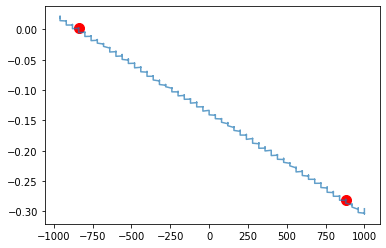

In [128]:
seg_ = 1
tp_1_i = 100
tp_2_i = -100

tp_1_m, tp_1_x1,  tp_1_y1,  tp_1_x2,  tp_1_y2 = data_seg[seg_]["motor"][tp_1_i], data_seg[seg_]["x1"][tp_1_i], data_seg[seg_]["y1"][tp_1_i], data_seg[seg_]["x2"][tp_1_i], data_seg[seg_]["y2"][tp_1_i]
tp_2_m, tp_2_x1,  tp_2_y1,  tp_2_x2,  tp_2_y2 = data_seg[seg_]["motor"][tp_2_i], data_seg[seg_]["x1"][tp_2_i], data_seg[seg_]["y1"][tp_2_i], data_seg[seg_]["x2"][tp_2_i], data_seg[seg_]["y2"][tp_2_i]

plt.scatter(tp_1_m, tp_1_y1, c="r", s=100)
plt.scatter(tp_2_m, tp_2_y1, c="r", s=100)
plt.plot(data_seg[seg_]["motor"], data_seg[seg_]["y1"], label=f"x1_seg{seg_}", alpha=0.7)

delta_m, delta_x1, delta_y1, delta_x2, delta_y2 = tp_2_m - tp_1_m, tp_2_x1 - tp_1_x1, tp_2_y1 - tp_1_y1, tp_2_x2 - tp_1_x2, tp_2_y2 - tp_1_y2

print(f"delta_m = {delta_m}, delta_x1 = {delta_x1:.4f}, delta_y1 = {delta_y1:.4f}, delta_x2 = {delta_x2:.4f}, delta_y2 = {delta_y2:.4f}")

In [129]:
delta_m_vec = np.array([0, delta_m, 0, 0])
delta_x_vec_cal = Mpnpp @ delta_m_vec
delta_x_vec_cal

array([-0.01010453,  0.28267266, -0.00124364,  0.13855993])

In [130]:
delta_x_vec = np.array([delta_x1, delta_y1, delta_x2, delta_y2])
delta_m_vec_cal = Anppp @ delta_x_vec
delta_m_vec_cal

array([ -230.11231271, -1331.21270197,   284.14973591,  -322.11010225])

In [131]:
Mnppn @ delta_m_vec_cal

array([-1.45369361e-02,  2.84659591e-01, -3.51759053e-05,  1.36036316e-01])

In [132]:
def m_matrix_select(m_vec):
    cand = np.array([Mpppp, Mpppn, Mppnp, Mppnn, Mpnpp, Mpnpn, Mpnnp, Mpnnn,
                     Mnppp, Mnppn, Mnpnp, Mnpnn, Mnnpp, Mnnpn, Mnnnp, Mnnnn])
    s = np.array((m_vec < 0), dtype=int)
    return cand[s[3] + (s[2] << 1) + (s[1] << 2) + (s[0] << 3)]

def a_matrix_select(m_vec):
    cand = np.array([Apppp, Apppn, Appnp, Appnn, Apnpp, Apnpn, Apnnp, Apnnn,
                     Anppp, Anppn, Anpnp, Anpnn, Annpp, Annpn, Annnp, Annnn])
    s = np.array((m_vec < 0), dtype=int)
    return cand[s[3] + (s[2] << 1) + (s[1] << 2) + (s[0] << 3)]

In [133]:
table = """ 0    | 0    | 0    | 0    | 0.1424 | -0.0433 | -0.1380 | 0.4651
500  | 0    | 0    | 0    | 0.0909 | -0.0462 | -0.1628 | 0.4597
500  | 500  | 0    | 0    | 0.0942 | -0.1342 | -0.1640 | 0.4198
500  | 500  | 500  | 0    | 0.0497 | -0.1316 | -0.1800 | 0.4225
500  | 500  | 500  | 500  | 0.0520 | -0.1966 | -0.1801 | 0.3999
0    | 500  | 500  | 500  | 0.1086 | -0.1937 | -0.1509 | 0.4006
0    | 0    | 500  | 500  | 0.1053 | -0.1130 | -0.1525 | 0.4428
0    | 0    | 0    | 500  | 0.1420 | -0.1157 | -0.1383 | 0.4402
0    | 0    | 0    | 0    | 0.1389 | -0.0520 | -0.1393 | 0.4623"""

m1_rs, m2_rs, m3_rs, m4_rs, x1_rs, y1_rs, x2_rs, y2_rs = [], [] ,[], [], [], [], [], []
for line in table.split("\n"):
    [arr.append(float(val)) for val, arr in zip(line.split("|"), [m1_rs, m2_rs, m3_rs, m4_rs, x1_rs, y1_rs, x2_rs, y2_rs])]

x1_cs, y1_cs, x2_cs, y2_cs = [], [] ,[], []
x1_cs.append(x1_rs[0])
y1_cs.append(y1_rs[0])
x2_cs.append(x2_rs[0])
y2_cs.append(y2_rs[0])

for i in range(1, len(m1_rs)):
    _delta_m_vec = np.array([m1_rs[i] - m1_rs[i-1],  m2_rs[i] - m2_rs[i-1], m3_rs[i] - m3_rs[i-1], m4_rs[i] - m4_rs[i-1]])
    _delta_x_vec_cal = m_matrix_select(_delta_m_vec) @ _delta_m_vec 
    
    _x_vec = np.array([x1_cs[i-1], y1_cs[i-1], x2_cs[i-1], y2_cs[i-1]]) + _delta_x_vec_cal
    
    [arr.append(float(val)) for val, arr in zip(_x_vec, [x1_cs, y1_cs, x2_cs, y2_cs])]

x1_diffs, y1_diffs, x2_diffs, y2_diffs = np.asarray(x1_cs) - np.asarray(x1_rs), np.asarray(y1_cs) - np.asarray(y1_rs), np.asarray(x2_cs) - np.asarray(x2_rs), np.asarray(y2_cs) - np.asarray(y2_rs) 

table = """| m1   | m2   | m3   | m4   | x1   | y1   | x2    | y2   | x1_c   | y1_c   | x2_c    | y2_c   | ϵx1   | ϵy1   | ϵx2    | ϵy2   |
|------|------|------|------|------|------|-------|------|------|------|-------|------|------|------|-------|------|
"""
for arr in zip(m1_rs, m2_rs, m3_rs, m4_rs, x1_rs, y1_rs, x2_rs, y2_rs, x1_cs, y1_cs, x2_cs, y2_cs, x1_diffs, y1_diffs, x2_diffs, y2_diffs):
    table += " | ".join([f"{a:.3f}" for a in arr])
    table += "|\n"

from IPython.display import display, Markdown
display(Markdown(table))

| m1   | m2   | m3   | m4   | x1   | y1   | x2    | y2   | x1_c   | y1_c   | x2_c    | y2_c   | ϵx1   | ϵy1   | ϵx2    | ϵy2   |
|------|------|------|------|------|------|-------|------|------|------|-------|------|------|------|-------|------|
0.000 | 0.000 | 0.000 | 0.000 | 0.142 | -0.043 | -0.138 | 0.465 | 0.142 | -0.043 | -0.138 | 0.465 | 0.000 | 0.000 | 0.000 | 0.000|
500.000 | 0.000 | 0.000 | 0.000 | 0.091 | -0.046 | -0.163 | 0.460 | 0.091 | -0.047 | -0.164 | 0.462 | 0.000 | -0.001 | -0.001 | 0.003|
500.000 | 500.000 | 0.000 | 0.000 | 0.094 | -0.134 | -0.164 | 0.420 | 0.095 | -0.136 | -0.163 | 0.418 | 0.001 | -0.001 | 0.001 | -0.002|
500.000 | 500.000 | 500.000 | 0.000 | 0.050 | -0.132 | -0.180 | 0.422 | 0.047 | -0.134 | -0.181 | 0.421 | -0.003 | -0.002 | -0.001 | -0.002|
500.000 | 500.000 | 500.000 | 500.000 | 0.052 | -0.197 | -0.180 | 0.400 | 0.050 | -0.202 | -0.180 | 0.398 | -0.002 | -0.005 | -0.000 | -0.002|
0.000 | 500.000 | 500.000 | 500.000 | 0.109 | -0.194 | -0.151 | 0.401 | 0.106 | -0.198 | -0.152 | 0.401 | -0.003 | -0.004 | -0.001 | -0.000|
0.000 | 0.000 | 500.000 | 500.000 | 0.105 | -0.113 | -0.152 | 0.443 | 0.103 | -0.116 | -0.152 | 0.441 | -0.003 | -0.003 | 0.000 | -0.002|
0.000 | 0.000 | 0.000 | 500.000 | 0.142 | -0.116 | -0.138 | 0.440 | 0.146 | -0.118 | -0.136 | 0.439 | 0.004 | -0.002 | 0.002 | -0.002|
0.000 | 0.000 | 0.000 | 0.000 | 0.139 | -0.052 | -0.139 | 0.462 | 0.143 | -0.048 | -0.137 | 0.462 | 0.004 | 0.004 | 0.002 | 0.000|


In [27]:
delta_x_vec = np.array((-0.00228, 0.06101, -0.00005, 0.01943))
delta_m_vec_cal = Anppp @ delta_x_vec
delta_m_vec_cal = a_matrix_select(delta_m_vec_cal) @ delta_x_vec
delta_m_vec_cal

array([ -30.16103,   52.88358,   34.49844, -500.22584])

## 10/26

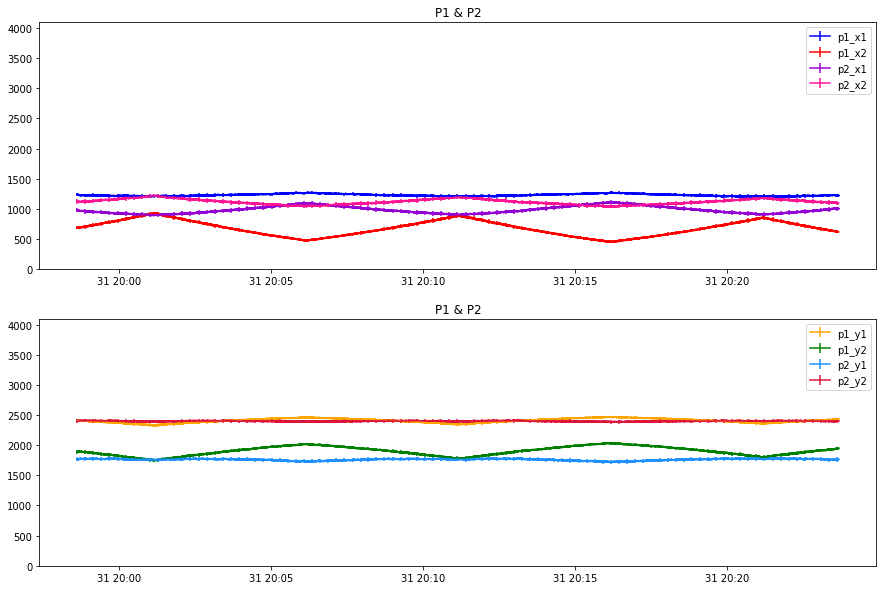

In [5]:
data_seg = []
for i in range(6):
    data = load_motor_data_file(f"2022-10-31T19_m1_seg{i}.txt")
    data_seg.append(data)

data = merge_seg_dict(data_seg)
plot_p1_p2(data)

In [6]:
m1_a_p, m1_a_n = fit_seg_m_to_p_vector(data_seg)

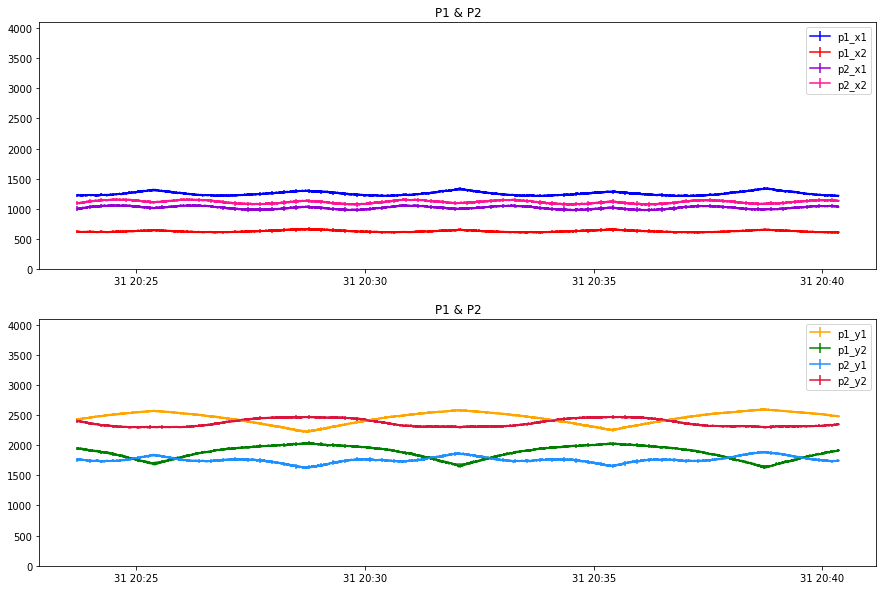

In [12]:
data_seg = []
for i in range(6):
    data = load_motor_data_file(f"2022-10-31T19_m2_seg{i}.txt")
    data_seg.append(data)

data = merge_seg_dict(data_seg)
plot_p1_p2(data)

In [13]:
m2_a_p, m2_a_n = fit_seg_m_to_p_vector(data_seg)

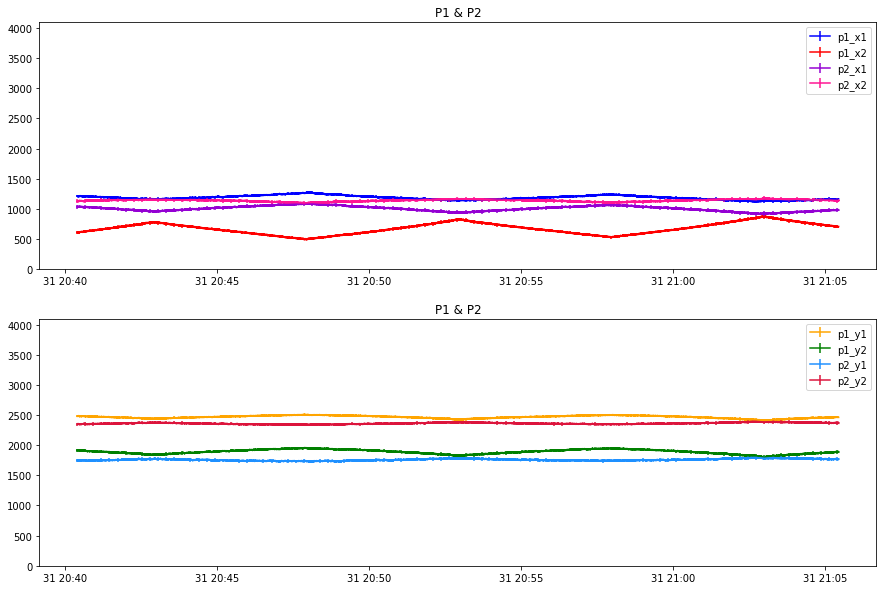

In [14]:
data_seg = []
for i in range(6):
    data = load_motor_data_file(f"2022-10-31T19_m3_seg{i}.txt")
    data_seg.append(data)

data = merge_seg_dict(data_seg)
plot_p1_p2(data)

In [15]:
m3_a_p, m3_a_n = fit_seg_m_to_p_vector(data_seg)

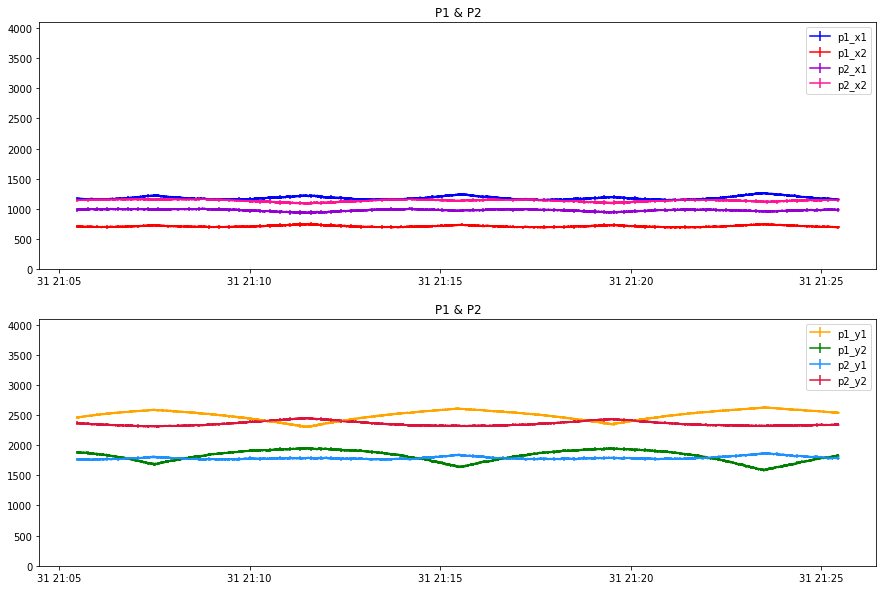

In [16]:
data_seg = []
for i in range(6):
    data = load_motor_data_file(f"2022-10-31T19_m4_seg{i}.txt")
    data_seg.append(data)

data = merge_seg_dict(data_seg)
plot_p1_p2(data)

In [17]:
m4_a_p, m4_a_n = fit_seg_m_to_p_vector(data_seg)

In [18]:
from numpy.linalg import inv

# Column vectors of A

m1_a_p_col = np.array([m1_a_p["x1"], m1_a_p["y1"], m1_a_p["x2"], m1_a_p["y2"]])
m2_a_p_col = np.array([m2_a_p["x1"], m2_a_p["y1"], m2_a_p["x2"], m2_a_p["y2"]])
m3_a_p_col = np.array([m3_a_p["x1"], m3_a_p["y1"], m3_a_p["x2"], m3_a_p["y2"]])
m4_a_p_col = np.array([m4_a_p["x1"], m4_a_p["y1"], m4_a_p["x2"], m4_a_p["y2"]])

m1_a_n_col = np.array([m1_a_n["x1"], m1_a_n["y1"], m1_a_n["x2"], m1_a_n["y2"]])
m2_a_n_col = np.array([m2_a_n["x1"], m2_a_n["y1"], m2_a_n["x2"], m2_a_n["y2"]])
m3_a_n_col = np.array([m3_a_n["x1"], m3_a_n["y1"], m3_a_n["x2"], m3_a_n["y2"]])
m4_a_n_col = np.array([m4_a_n["x1"], m4_a_n["y1"], m4_a_n["x2"], m4_a_n["y2"]])


# filtering
# m1_a_p_col[abs(m1_a_p_col) < 1e-6] = 0
# m2_a_p_col[abs(m2_a_p_col) < 1e-6] = 0
# m3_a_p_col[abs(m3_a_p_col) < 1e-6] = 0
# m4_a_p_col[abs(m4_a_p_col) < 1e-6] = 0
# m1_a_n_col[abs(m1_a_n_col) < 1e-6] = 0
# m2_a_n_col[abs(m2_a_n_col) < 1e-6] = 0
# m3_a_n_col[abs(m3_a_n_col) < 1e-6] = 0
# m4_a_n_col[abs(m4_a_n_col) < 1e-6] = 0


# 16 matrices

Mpppp = np.array([m1_a_p_col, m2_a_p_col, m3_a_p_col, m4_a_p_col]).transpose()
Mpppn = np.array([m1_a_p_col, m2_a_p_col, m3_a_p_col, m4_a_n_col]).transpose()
Mppnp = np.array([m1_a_p_col, m2_a_p_col, m3_a_n_col, m4_a_p_col]).transpose()
Mpnpp = np.array([m1_a_p_col, m2_a_n_col, m3_a_p_col, m4_a_p_col]).transpose()
Mnppp = np.array([m1_a_n_col, m2_a_p_col, m3_a_p_col, m4_a_p_col]).transpose()
Mppnn = np.array([m1_a_p_col, m2_a_p_col, m3_a_n_col, m4_a_n_col]).transpose()
Mpnpn = np.array([m1_a_p_col, m2_a_n_col, m3_a_p_col, m4_a_n_col]).transpose()
Mpnnp = np.array([m1_a_p_col, m2_a_n_col, m3_a_n_col, m4_a_p_col]).transpose()
Mnppn = np.array([m1_a_n_col, m2_a_p_col, m3_a_p_col, m4_a_n_col]).transpose()
Mnpnp = np.array([m1_a_n_col, m2_a_p_col, m3_a_n_col, m4_a_p_col]).transpose()
Mnnpp = np.array([m1_a_n_col, m2_a_n_col, m3_a_p_col, m4_a_p_col]).transpose()
Mnnnp = np.array([m1_a_n_col, m2_a_n_col, m3_a_n_col, m4_a_p_col]).transpose()
Mnnpn = np.array([m1_a_n_col, m2_a_n_col, m3_a_p_col, m4_a_n_col]).transpose()
Mnpnn = np.array([m1_a_n_col, m2_a_p_col, m3_a_n_col, m4_a_n_col]).transpose()
Mpnnn = np.array([m1_a_p_col, m2_a_n_col, m3_a_n_col, m4_a_n_col]).transpose()
Mnnnn = np.array([m1_a_n_col, m2_a_n_col, m3_a_n_col, m4_a_n_col]).transpose()

Apppp = np.array(inv(Mpppp), dtype=int)
Apppn = np.array(inv(Mpppn), dtype=int)
Appnp = np.array(inv(Mppnp), dtype=int)
Apnpp = np.array(inv(Mpnpp), dtype=int)
Anppp = np.array(inv(Mnppp), dtype=int)
Appnn = np.array(inv(Mppnn), dtype=int)
Apnpn = np.array(inv(Mpnpn), dtype=int)
Apnnp = np.array(inv(Mpnnp), dtype=int)
Anppn = np.array(inv(Mnppn), dtype=int)
Anpnp = np.array(inv(Mnpnp), dtype=int)
Annpp = np.array(inv(Mnnpp), dtype=int)
Annnp = np.array(inv(Mnnnp), dtype=int)
Annpn = np.array(inv(Mnnpn), dtype=int)
Anpnn = np.array(inv(Mnpnn), dtype=int)
Apnnn = np.array(inv(Mpnnn), dtype=int)
Annnn = np.array(inv(Mnnnn), dtype=int)

In [19]:
combs = [
    ('P', 'P', 'P', 'P', Apppp),
    ('P', 'P', 'P', 'N', Apppn),
    ('P', 'P', 'N', 'P', Appnp),
    ('P', 'P', 'N', 'N', Appnn),
    ('P', 'N', 'P', 'P', Apnpp),
    ('P', 'N', 'P', 'N', Apnpn),
    ('P', 'N', 'N', 'P', Apnnp),
    ('P', 'N', 'N', 'N', Apnnn),
    ('N', 'P', 'P', 'P', Anppp),
    ('N', 'P', 'P', 'N', Anppn),
    ('N', 'P', 'N', 'P', Anpnp),
    ('N', 'P', 'N', 'N', Anpnn),
    ('N', 'N', 'P', 'P', Annpp),
    ('N', 'N', 'P', 'N', Annpn),
    ('N', 'N', 'N', 'P', Annnp),
    ('N', 'N', 'N', 'N', Annnn)
]

code = ""
for m1dir, m2dir, m3dir, m4dir, b in combs:
    code += f"""const PositionMotionMatrix POS_MTR_MTX_{m1dir}_{m2dir}_{m3dir}_{m4dir} = {{
    {{
        {{ {b[0][0]:>7d}, {b[0][1]:>7d}, {b[0][2]:>7d}, {b[0][3]:>7d} }},
        {{ {b[1][0]:>7d}, {b[1][1]:>7d}, {b[1][2]:>7d}, {b[1][3]:>7d} }},
        {{ {b[2][0]:>7d}, {b[2][1]:>7d}, {b[2][2]:>7d}, {b[2][3]:>7d} }},
        {{ {b[3][0]:>7d}, {b[3][1]:>7d}, {b[3][2]:>7d}, {b[3][3]:>7d} }},
    }}
}};
    
"""
    
print(code)

const PositionMotionMatrix POS_MTR_MTX_P_P_P_P = {
    {
        {   21015,    2384,  -59648,   -2786 },
        {   -2478,    8862,    5385,  -31338 },
        {  -34409,   -3170,   67786,    3003 },
        {    1970,  -20767,   -3759,   45933 },
    }
};
    
const PositionMotionMatrix POS_MTR_MTX_P_P_P_N = {
    {
        {   21040,    2118,  -59697,   -2199 },
        {   -2532,    9433,    5488,  -32601 },
        {  -34438,   -2869,   67840,    2337 },
        {    2246,  -23667,   -4284,   52347 },
    }
};
    
const PositionMotionMatrix POS_MTR_MTX_P_P_N_P = {
    {
        {   21209,    2402,  -60031,   -2803 },
        {   -2280,    8880,    4994,  -31356 },
        {  -39468,   -3636,   77752,    3444 },
        {    1509,  -20810,   -2850,   45973 },
    }
};
    
const PositionMotionMatrix POS_MTR_MTX_P_P_N_N = {
    {
        {   21228,    2134,  -60068,   -2211 },
        {   -2321,    9451,    5073,  -32616 },
        {  -39493,   -3290,   77799,    2681 },
        { 

In [5]:
def avg_at_each_motor_pos(data):
    motor_segs = []
    x1_segs = []
    y1_segs = []
    err_x1_segs = []
    err_y1_segs = []
    
    last_motor = None
    
    for m, x1, y1, err_x1, err_y1 in zip(data["motor"], data["x1"], data["y1"], data["err_x1"], data["err_y1"]):
        if m != last_motor:
            last_motor = m
            motor_segs.append(m)
            [a.append([]) for a in (x1_segs, y1_segs, err_x1_segs, err_y1_segs)]

        [a[-1].append(b) for a, b in [
            (x1_segs, x1),
            (y1_segs, y1),
            (err_x1_segs, err_x1),
            (err_y1_segs, err_y1),
        ]]
        
    data["motor_avgs"] = motor_segs
    data["x1_avgs"] = np.array([np.average(a[1:]) for a in x1_segs])
    data["y1_avgs"] = np.array([np.average(a[1:]) for a in y1_segs])
    data["err_x1_avgs"] = np.array([np.average(a[1:]) for a in err_x1_segs])
    data["err_y1_avgs"] = np.array([np.average(a[1:]) for a in err_y1_segs])

In [12]:
data_seg = []
for i in range(6):
    ## IMPORTANT NOTE: all variance quote here is the real variance, not standard error^2.
    ## To convert it into standard error, one need to take sqrt(variance)/sqrt(average count)
    ## On Sept. 4th, the average count is 200.
    ## All these information can be confirmed by digging into the VCS (Teensy should be running on commit 4c347ad on Sept. 4th).
    data = load_motor_data_file(f"2022-09-04T18_m1_seg{i}.txt")
    avg_at_each_motor_pos(data)
    data_seg.append(data)

    
for i, data in enumerate(data_seg):
    #kx1, bx1, rx1, px1, sex1 = linregress(data["motor"][s:e], data["x1"][s:e])
    data["x1_fit"] = linregress(data["motor"], data["x1"])
    data["x2_fit"] = linregress(data["motor"], data["x2"])
    data["y1_fit"] = linregress(data["motor"], data["y1"])
    data["y2_fit"] = linregress(data["motor"], data["y2"])
    

data = data_seg[4]

### PSD voltage error

In [13]:
## p1 y1 voltage uncertainty of a single reading
p1_y1_uncertainty = np.sqrt(np.average(np.asarray(data["p1_err_y1s"])[np.equal(data["motor"], -1380)][1:20]))/4096*3.3

## p1 y1 voltage standard error of after averaging 200 times
p1_y1_std_err = np.sqrt(np.average(np.asarray(data["p1_err_y1s"])[np.equal(data["motor"], -1380)][1:20]))/4096*3.3/np.sqrt(200)

print(f"p1_y1 voltage uncertainty = {p1_y1_uncertainty:.3f} V")
print(f"p1_y1 voltage standard error = {p1_y1_std_err:.3f} V")

## p1 x1 voltage uncertainty of a single reading
p1_x1_uncertainty = np.sqrt(np.average(np.asarray(data["p1_err_x1s"])[np.equal(data["motor"], -1380)][1:20]))/4096*3.3

## p1 x1 voltage standard error of after averaging 200 times
p1_x1_std_err = np.sqrt(np.average(np.asarray(data["p1_err_x1s"])[np.equal(data["motor"], -1380)][1:20]))/4096*3.3/np.sqrt(200)

print(f"p1_x1 voltage uncertainty = {p1_x1_uncertainty:.3f} V")
print(f"p1_x1 voltage standard error = {p1_x1_std_err:.3f} V")

## p1 y2 voltage uncertainty of a single reading
p1_y2_uncertainty = np.sqrt(np.average(np.asarray(data["p1_err_y2s"])[np.equal(data["motor"], -1380)][1:20]))/4096*3.3

## p1 y2 voltage standard error of after averaging 200 times
p1_y2_std_err = np.sqrt(np.average(np.asarray(data["p1_err_y2s"])[np.equal(data["motor"], -1380)][1:20]))/4096*3.3/np.sqrt(200)

print(f"p1_y2 voltage uncertainty = {p1_y2_uncertainty:.3f} V")
print(f"p1_y2 voltage standard error = {p1_y2_std_err:.3f} V")

## p1 x2 voltage uncertainty of a single reading
p1_x2_uncertainty = np.sqrt(np.average(np.asarray(data["p1_err_x2s"])[np.equal(data["motor"], -1380)][1:20]))/4096*3.3

## p1 x2 voltage standard error of after averaging 200 times
p1_x2_std_err = np.sqrt(np.average(np.asarray(data["p1_err_x2s"])[np.equal(data["motor"], -1380)][1:20]))/4096*3.3/np.sqrt(200)

print(f"p1_x2 voltage uncertainty = {p1_x2_uncertainty:.3f} V")
print(f"p1_x2 voltage standard error = {p1_x2_std_err:.3f} V")

p1_y1 voltage uncertainty = 0.026 V
p1_y1 voltage standard error = 0.002 V
p1_x1 voltage uncertainty = 0.027 V
p1_x1 voltage standard error = 0.002 V
p1_y2 voltage uncertainty = 0.029 V
p1_y2 voltage standard error = 0.002 V
p1_x2 voltage uncertainty = 0.030 V
p1_x2 voltage standard error = 0.002 V


In [14]:
## p2 y1 voltage uncertainty of a single reading
p2_y1_uncertainty = np.sqrt(np.average(np.asarray(data["p2_err_y1s"])[np.equal(data["motor"], -1380)][1:20]))/4096*3.3

## p2 y1 voltage standard error of after averaging 200 times
p2_y1_std_err = np.sqrt(np.average(np.asarray(data["p2_err_y1s"])[np.equal(data["motor"], -1380)][1:20]))/4096*3.3/np.sqrt(200)

print(f"p2_y1 voltage uncertainty = {p2_y1_uncertainty:.3f} V")
print(f"p2_y1 voltage standard error = {p2_y1_std_err:.3f} V")

## p2 x1 voltage uncertainty of a single reading
p2_x1_uncertainty = np.sqrt(np.average(np.asarray(data["p2_err_x1s"])[np.equal(data["motor"], -1380)][1:20]))/4096*3.3

## p2 x1 voltage standard error of after averaging 200 times
p2_x1_std_err = np.sqrt(np.average(np.asarray(data["p2_err_x1s"])[np.equal(data["motor"], -1380)][1:20]))/4096*3.3/np.sqrt(200)

print(f"p2_x1 voltage uncertainty = {p2_x1_uncertainty:.3f} V")
print(f"p2_x1 voltage standard error = {p2_x1_std_err:.3f} V")

## p2 y2 voltage uncertainty of a single reading
p2_y2_uncertainty = np.sqrt(np.average(np.asarray(data["p2_err_y2s"])[np.equal(data["motor"], -1380)][1:20]))/4096*3.3

## p2 y2 voltage standard error of after averaging 200 times
p2_y2_std_err = np.sqrt(np.average(np.asarray(data["p2_err_y2s"])[np.equal(data["motor"], -1380)][1:20]))/4096*3.3/np.sqrt(200)

print(f"p2_y2 voltage uncertainty = {p2_y2_uncertainty:.3f} V")
print(f"p2_y2 voltage standard error = {p2_y2_std_err:.3f} V")

## p2 x2 voltage uncertainty of a single reading
p2_x2_uncertainty = np.sqrt(np.average(np.asarray(data["p2_err_x2s"])[np.equal(data["motor"], -1380)][1:20]))/4096*3.3

## p2 x2 voltage standard error of after averaging 200 times
p2_x2_std_err = np.sqrt(np.average(np.asarray(data["p2_err_x2s"])[np.equal(data["motor"], -1380)][1:20]))/4096*3.3/np.sqrt(200)

print(f"p2_x2 voltage uncertainty = {p2_x2_uncertainty:.3f} V")
print(f"p2_x2 voltage standard error = {p2_x2_std_err:.3f} V")

p2_y1 voltage uncertainty = 0.027 V
p2_y1 voltage standard error = 0.002 V
p2_x1 voltage uncertainty = 0.027 V
p2_x1 voltage standard error = 0.002 V
p2_y2 voltage uncertainty = 0.023 V
p2_y2 voltage standard error = 0.002 V
p2_x2 voltage uncertainty = 0.028 V
p2_x2 voltage standard error = 0.002 V


### Detection error calculation

x1 err (calculated from a single x1 measurement (including 200 times average)) = 3.490 um
x1 err (calculated with result across a series of x1 measurements) = 6.253 um


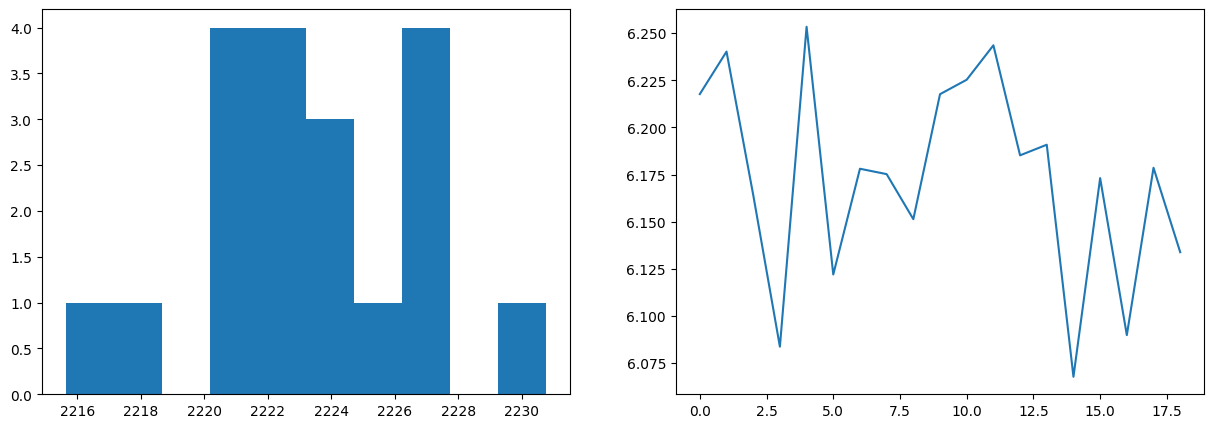

In [15]:
x1_cut = np.asarray(data["x1"])[np.equal(data["motor"], -1380)][1:20] * 5000 # in um
err_x1_cut = np.asarray(data["err_x1"])[np.equal(data["motor"], -1380)][1:20]/np.sqrt(200) * 5000 # in um
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(x1_cut)  # histogram showing the distribution of measured value
plt.subplot(122)
plt.plot(err_x1_cut)  # the standard error of each measurement
print("x1 err (calculated from a single x1 measurement (including 200 times average)) = {:.3f} um".format(np.std(x1_cut)))
print("x1 err (calculated with result across a series of x1 measurements) = {:.3f} um".format(max(err_x1_cut)))

y1 err (calculated from a single y1 measurement (including 200 times average)) = 3.179 um
y1 err (calculated with result across a series of y1 measurements) = 5.475 um


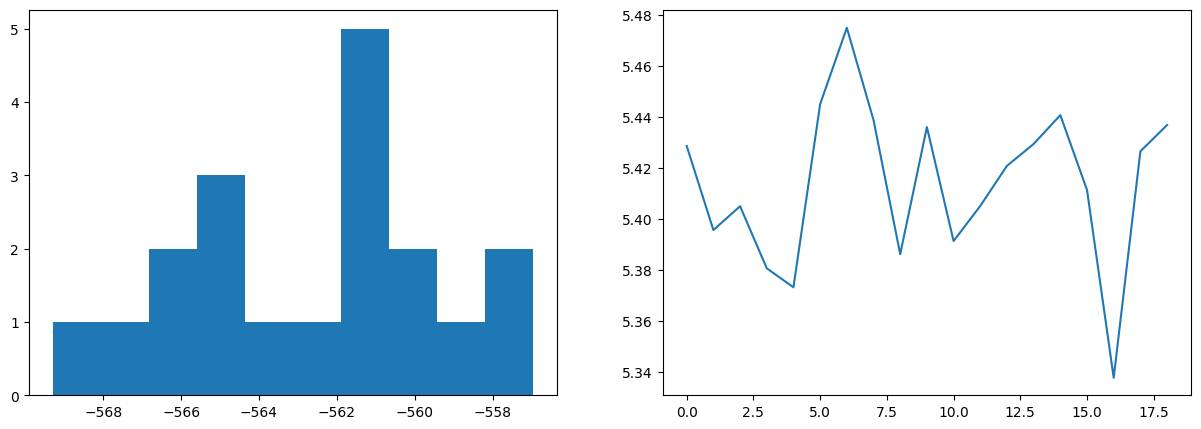

In [16]:
y1_cut = np.asarray(data["y1"])[np.equal(data["motor"], -1380)][1:20] * 5000 # in um
err_y1_cut = np.asarray(data["err_y1"])[np.equal(data["motor"], -1380)][1:20]/np.sqrt(200) * 5000 # in um
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(y1_cut)  # histogram showing the distribution of measured value
plt.subplot(122)
plt.plot(err_y1_cut)  # the standard error of each measurement
print("y1 err (calculated from a single y1 measurement (including 200 times average)) = {:.3f} um".format(np.std(y1_cut)))
print("y1 err (calculated with result across a series of y1 measurements) = {:.3f} um".format(max(err_y1_cut)))

x2 err (calculated from a single x2 measurement (including 200 times average)) = 3.387 um
x2 err (calculated with result across a series of x2 measurements) = 5.328 um


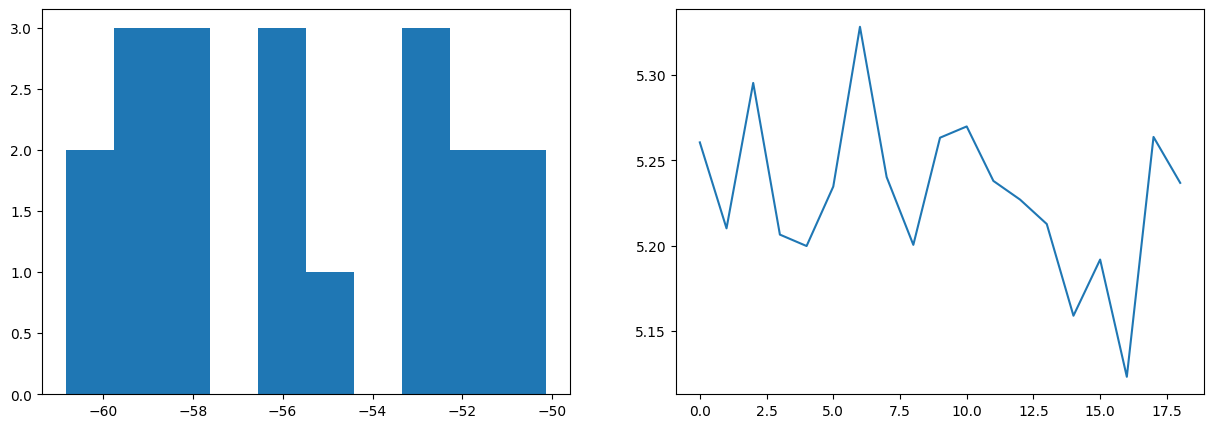

In [17]:
x2_cut = np.asarray(data["x2"])[np.equal(data["motor"], -1380)][1:20] * 5000 # in um
err_x2_cut = np.asarray(data["err_x2"])[np.equal(data["motor"], -1380)][1:20]/np.sqrt(200) * 5000 # in um
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(x2_cut)  # histogram showing the distribution of measured value
plt.subplot(122)
plt.plot(err_x2_cut)  # the standard error of each measurement
print("x2 err (calculated from a single x2 measurement (including 200 times average)) = {:.3f} um".format(np.std(x2_cut)))
print("x2 err (calculated with result across a series of x2 measurements) = {:.3f} um".format(max(err_x2_cut)))

y2 err (calculated from a single y2 measurement (including 200 times average)) = 3.341 um
y2 err (calculated with result across a series of y2 measurements) = 5.244 um


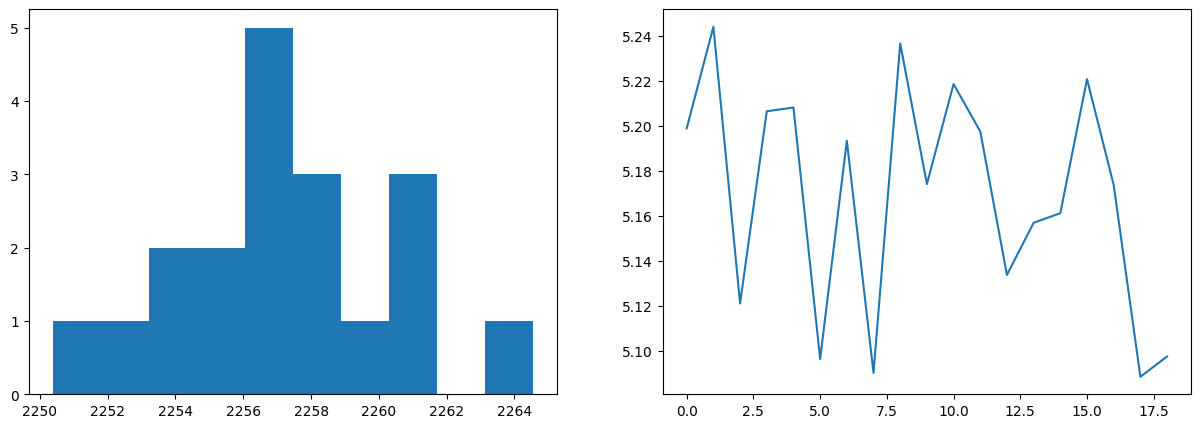

In [18]:
y2_cut = np.asarray(data["y2"])[np.equal(data["motor"], -1380)][1:20] * 5000 # in um
err_y2_cut = np.asarray(data["err_y2"])[np.equal(data["motor"], -1380)][1:20]/np.sqrt(200) * 5000 # in um
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(y2_cut)  # histogram showing the distribution of measured value
plt.subplot(122)
plt.plot(err_y2_cut)  # the standard error of each measurement
print("y2 err (calculated from a single y2 measurement (including 200 times average)) = {:.3f} um".format(np.std(y2_cut)))
print("y2 err (calculated with result across a series of y2 measurements) = {:.3f} um".format(max(err_y2_cut)))

### Fiber coupling performance figure

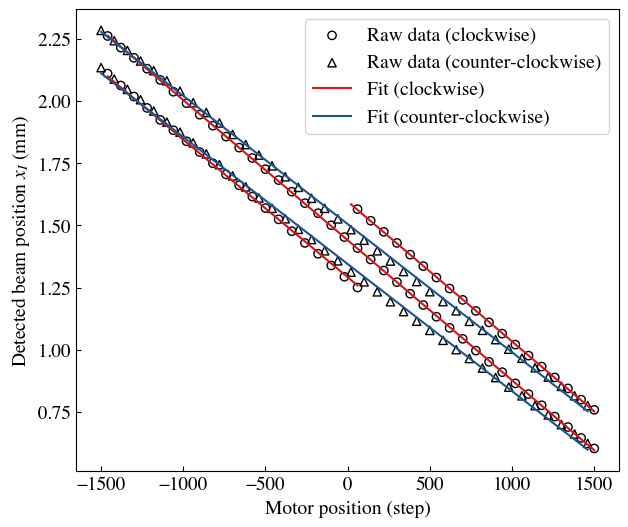

In [19]:
import matplotlib
matplotlib.rcParams['font.family'] = ['Times', 'serif']
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.size'] = "14"

red = "#ce181e"
blue = "#1b5692"

fig = plt.figure(figsize=(7, 6))

plt.scatter(data_seg[1]["motor_avgs"][36:][::2], 5*data_seg[1]["x1_avgs"][36:][::2], color="black", facecolors='none', marker="o", label="Raw data (clockwise)")
plt.scatter(data_seg[2]["motor_avgs"][::2], 5*data_seg[2]["x1_avgs"][::2], color="black", facecolors='none', marker="^", label="Raw data (counter-clockwise)")
plt.scatter(data_seg[3]["motor_avgs"][::2], 5*data_seg[3]["x1_avgs"][::2], color="black", facecolors='none', marker="o")
plt.scatter(data_seg[4]["motor_avgs"][::2], 5*data_seg[4]["x1_avgs"][::2], color="black", facecolors='none', marker="^")
plt.scatter(data_seg[5]["motor_avgs"][::2], 5*data_seg[5]["x1_avgs"][::2], color="black", facecolors='none', marker="o")

seg1_fit_ms = np.linspace(data_seg[1]["motor_avgs"][36], data_seg[1]["motor_avgs"][-1], 100)
seg2_fit_ms = np.linspace(data_seg[2]["motor_avgs"][0], data_seg[2]["motor_avgs"][-1], 100)
seg3_fit_ms = np.linspace(data_seg[3]["motor_avgs"][0], data_seg[3]["motor_avgs"][-1], 100)
seg4_fit_ms = np.linspace(data_seg[4]["motor_avgs"][0], data_seg[4]["motor_avgs"][-1], 100)
seg5_fit_ms = np.linspace(data_seg[5]["motor_avgs"][0], data_seg[5]["motor_avgs"][-1], 100)

plt.plot(seg1_fit_ms, 5*(data_seg[1]["x1_fit"][0] * seg1_fit_ms + data_seg[1]["x1_fit"][1]), color=red, label="Fit (clockwise)")
plt.plot(seg2_fit_ms, 5*(data_seg[2]["x1_fit"][0] * seg2_fit_ms + data_seg[2]["x1_fit"][1]), color=blue, label="Fit (counter-clockwise)")
plt.plot(seg3_fit_ms, 5*(data_seg[3]["x1_fit"][0] * seg3_fit_ms + data_seg[3]["x1_fit"][1]), color=red)
plt.plot(seg4_fit_ms, 5*(data_seg[4]["x1_fit"][0] * seg4_fit_ms + data_seg[4]["x1_fit"][1]), color=blue)
plt.plot(seg5_fit_ms, 5*(data_seg[5]["x1_fit"][0] * seg5_fit_ms + data_seg[5]["x1_fit"][1]), color=red)

plt.xlabel("Motor position (step)")
plt.ylabel(r"Detected beam position $x_{I}$ (mm)")

plt.legend()
plt.gca().tick_params(direction='in')

#axin = plt.gca().inset_axes([0.1, 0.2, 0.3, 0.3])
#axin.errorbar(motor_segs, x1_avgs, yerr=err_x1_avgs/np.sqrt(200), color="#00c16e", marker="x")
#
#axin.set_xlim(-500, -300)
#axin.set_ylim(0.33, 0.345)

#plt.gca().indicate_inset_zoom(axin)

#plt.subplot(2, 1, 2)
#plt.title("P2")
#plt.errorbar(data["motor"], data["x2"], yerr=data["err_x2"]/np.sqrt(200), color="tab:red", fmt="o", markersize=0.1, label="x1")
#plt.errorbar(data["motor"], data["y2"], yerr=data["err_y2"]/np.sqrt(200), color="tab:green", fmt="o", markersize=0.1, label="x1")
fig.savefig("calibration_xy.svg", format="svg", dpi=300)

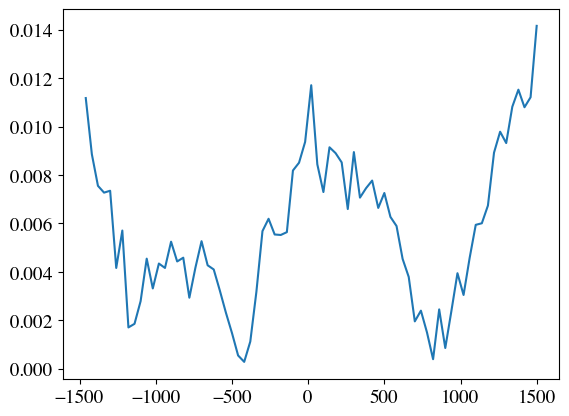

In [20]:
plt.plot(data_seg[1]["motor_avgs"], (abs(5*np.asarray(data_seg[1]["x1_avgs"]) - 5*(data_seg[1]["x1_fit"][0] * np.asarray(data_seg[1]["motor_avgs"]) + data_seg[1]["x1_fit"][1]))))

In [21]:
hist, bins = np.histogram((abs(5*np.asarray(data_seg[1]["x1_avgs"]) - 5*(data_seg[1]["x1_fit"][0] * np.asarray(data_seg[1]["motor_avgs"]) + data_seg[1]["x1_fit"][1]))), density=True)

In [22]:
[sum(hist[0:i] * np.diff(bins)[0]) for i in range(len(hist))]

[0,
 0.09333333333333334,
 0.22666666666666668,
 0.38666666666666666,
 0.5333333333333333,
 0.6533333333333333,
 0.7999999999999999,
 0.9066666666666667,
 0.9600000000000001,
 0.9866666666666667]

In [23]:
bins

array([0.00028126, 0.00166905, 0.00305683, 0.00444461, 0.00583239,
       0.00722018, 0.00860796, 0.00999574, 0.01138352, 0.01277131,
       0.01415909])

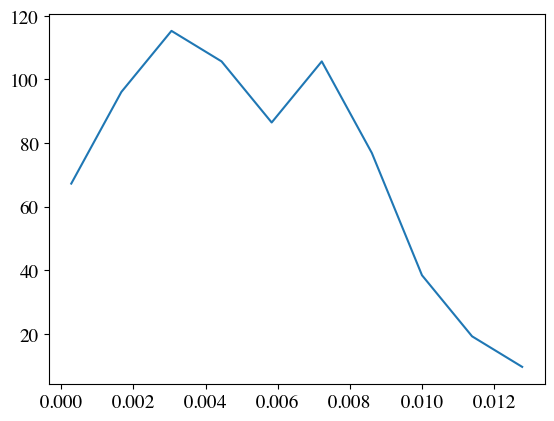

In [24]:
plt.plot(bins[0:-1], hist)

In [25]:
(data_seg[1]["x1_fit"][0] - data_seg[2]["x1_fit"][0])*5

-4.183623901093512e-05

(0.32, 0.355)

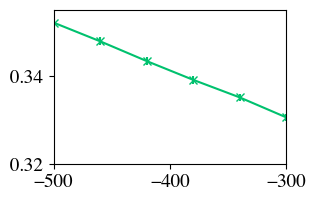

In [30]:
fig = plt.figure(figsize=(3, 2))

#plt.title("P1")
#plt.errorbar(data["motor"], data["x1"], yerr=data["err_x1"]/np.sqrt(200), color="tab:orange", fmt="o", markersize=0.1, label="x1")
#plt.errorbar(data["motor"], data["y1"], yerr=data["err_y1"]/np.sqrt(200), color="tab:blue", fmt="o", markersize=0.1, label="y1")

plt.errorbar(data["motor_avgs"], data["x1_avgs"], yerr=data["err_x1_avgs"]/np.sqrt(200), color="#00c16e", marker="x", label=r"$x_{\mathrm{I}}$")
#plt.errorbar(motor_segs, y1_avgs, yerr=err_y1_avgs/np.sqrt(200), color="#7552cc", marker="x", label=r"$y_{\mathrm{I}}$")

plt.xlim(-500, -300)
plt.ylim(0.32, 0.355)

#plt.legend()

## Fiber Coupling Test Performance

In [31]:
table = """0.8 | 7.2 | 9.1 | 9.1 | 9.2 | 9.1 | 9.1
0.8 | 7.2 | 9.2 | 9.2 | 9.0 | 9.2 | 9.1
0.8 | 7.2 | 9.1 | 9.2 | 9.1 | 9.2 | 9.2
0.8 | 7.2 | 9.1 | 9.2 | 9.2 | 9.2 | 9.2
0.5 | 4.5 | 9.2 | 9.2 | 9.0 | 9.2 | 9.2
0.5 | 4.5 | 9.2 | 9.1 | 9.1 | 9.2 | 9.2
0.5 | 4.5 | 8.8 | 9.1 | 9.2 | 9.1 | 9.2
0.5 | 4.5 | 8.3 | 8.6 | 9.2 | 9.1 | 9.1
0.2 | 1.8 | 8.7 | 9.1 | 9.1 | 9.1 | 9.1
0.2 | 1.9 | 9.2 | 9.1 | 9.0 | 9.1 | 9.1
0.2 | 1.9 | 8.9 | 9.1 | 9.1 | 9.1 | 9.1
0.2 | 1.8 | 8.0 | 8.5 | 9.2 | 9.2 | 9.0
0.1 | 0.9 | 8.5 | 9.0 | 9.1 | 9.0 | 9.1
0.1 | 0.9 | 9.2 | 9.0 | 9.1 | 8.9 | 8.9
0.1 | 0.8 | 9.2 | 9.1 | 9.1 | 9.0 | 9.2
0.1 | 0.9 | 7.0 | 8.1 | 8.9 | 9.0 | 9.0
0.003 | 0.3 | 8.6 | 8.5 | 9.1 | 8.9 | 9.1
0.003 | 0.3 | 8.3 | 8.5 | 9.0 | 9.0 | 9.0
0.003 | 0.3 | 8.6 | 9.0 | 9.1 | 9.1 | 8.9
0.003 | 0.3 | 7.5 | 8.2 | 8.9 | 9.0 | 8.8"""

curves = {}
max_power = 9.2

for line in table.split("\n"):
    buf = [ float(a) for a in line.split("|") ]
    if buf[0] not in curves:
        curves[buf[0]] = []
    curves[buf[0]].append(buf[1:])

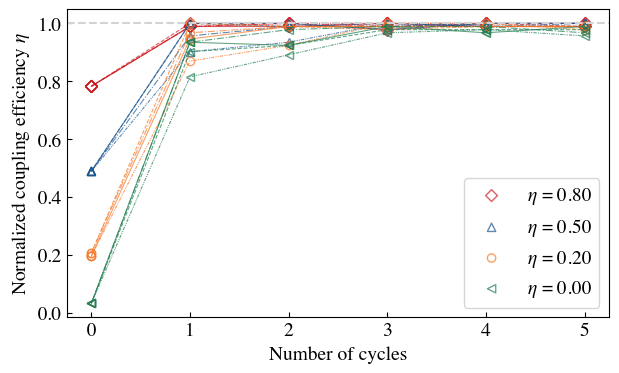

In [32]:
import matplotlib
matplotlib.rcParams['font.family'] = ['Times', 'serif']
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.size'] = "14"

fig = plt.figure(figsize=(7, 4))

colors = {'red': "#ce181e", 
         'blue': "#1b5692",
         'orange': "#f67828",
         'purple': "#52057f",
         'green': "#237f52"}

markers = ["D", "^", "o", "x", "<"]
linestyles = ["-", "--", "-.", (0, (3, 1, 1, 1, 1, 1))]

for (eta, _curves), color, marker in zip(curves.items(), colors.values(), markers):
    if eta == 0.1:
        continue
    lbl = False
    for _c, ls in zip(_curves, linestyles):
        if not lbl:
            plt.scatter(range(len(_c)), np.asarray(_c)/max_power, color=color, marker=marker, fc="none", alpha=0.7, label=f"$\eta$ = {eta:.2f}")
            lbl = True
        plt.plot(np.asarray(_c)/max_power, color=color, linewidth=0.8, marker=marker, mfc="none", alpha=0.7, linestyle=ls)

plt.axhline(1, linestyle="--", color="lightgrey")

plt.xlabel("Number of cycles")
plt.ylabel(r"Normalized coupling efficiency $\eta$")

plt.legend()
#plt.yscale("log")
plt.gca().tick_params(direction='in')

#axin = plt.gca().inset_axes([0.1, 0.2, 0.3, 0.3])
#axin.errorbar(motor_segs, x1_avgs, yerr=err_x1_avgs/np.sqrt(200), color="#00c16e", marker="x")
#
#axin.set_xlim(-500, -300)
#axin.set_ylim(0.33, 0.345)

#plt.gca().indicate_inset_zoom(axin)

#plt.subplot(2, 1, 2)
#plt.title("P2")
#plt.errorbar(data["motor"], data["x2"], yerr=data["err_x2"]/np.sqrt(200), color="tab:red", fmt="o", markersize=0.1, label="x1")
#plt.errorbar(data["motor"], data["y2"], yerr=data["err_y2"]/np.sqrt(200), color="tab:green", fmt="o", markersize=0.1, label="x1")
fig.savefig("coupling_performance.svg", format="svg", dpi=300)

## Jump data analysis

In [33]:
def load_jump_data_file(file):
    with open(file, "r") as f:
        data = {
            "ts": [],
            "jmp": [],
            "pwr": [],
            "p1_x1s": [],
            "p1_x2s": [],
            "p1_y1s": [],
            "p1_y2s": [],
            "p1_err_x1s": [],
            "p1_err_x2s": [],
            "p1_err_y1s": [],
            "p1_err_y2s": [],
            "p2_x1s": [],
            "p2_x2s": [],
            "p2_y1s": [],
            "p2_y2s": [],
            "p2_err_x1s": [],
            "p2_err_x2s": [],
            "p2_err_y1s": [],
            "p2_err_y2s": [],
            "x1": [],
            "y1": [],
            "x2": [],
            "y2": [],
            "err_x1": [],
            "err_y1": [],
            "err_x2": [],
            "err_y2": []
        }
        
        time1 = 0

        for line in f:
            _, jmp, _, pwr, r, time, x1, x2, y1, y2, err_x1, err_x2, err_y1, err_y2 = line.split()

            if r == "r1":
                time1 = int(time)
                data["ts"].append(datetime.fromtimestamp(int(time)))
                data["jmp"].append(int(jmp))
                data["pwr"].append(float(pwr))
                data["p1_x1s"].append(int(x1))
                data["p1_x2s"].append(int(x2))
                data["p1_y1s"].append(int(y1))
                data["p1_y2s"].append(int(y2))
                data["p1_err_x1s"].append(int(err_x1))
                data["p1_err_x2s"].append(int(err_x2))
                data["p1_err_y1s"].append(int(err_y1))
                data["p1_err_y2s"].append(int(err_y2))
                
                x1_ = int(x1) - p1_x1_offset
                x2_ = int(x2) - p1_x2_offset
                y1_ = int(y1) - p1_y1_offset
                y2_ = int(y2) - p1_y2_offset
                
                x = (x1_ - x2_) / (x1_ + x2_)
                y = (y1_ - y2_) / (y1_ + y2_)
                
                err_x = quotient_err(x1_, x2_, int(err_x1), int(err_x2))
                err_y = quotient_err(y1_, y2_, int(err_y1), int(err_y2))
                
                data["x1"].append(x)
                data["y1"].append(y)
                data["err_x1"].append(err_x)
                data["err_y1"].append(err_y)
                
            elif r == "r2":
                data["p2_x1s"].append(int(x1))
                data["p2_x2s"].append(int(x2))
                data["p2_y1s"].append(int(y1))
                data["p2_y2s"].append(int(y2))
                data["p2_err_x1s"].append(int(err_x1))
                data["p2_err_x2s"].append(int(err_x2))
                data["p2_err_y1s"].append(int(err_y1))
                data["p2_err_y2s"].append(int(err_y2))
                
                x1_ = int(x1) - p2_x1_offset
                x2_ = int(x2) - p2_x2_offset
                y1_ = int(y1) - p2_y1_offset
                y2_ = int(y2) - p2_y2_offset
                
                x = (x1_ - x2_) / (x1_ + x2_)
                y = (y1_ - y2_) / (y1_ + y2_)
                
                err_x = quotient_err(x1_, x2_, int(err_x1), int(err_x2))
                err_y = quotient_err(y1_, y2_, int(err_y1), int(err_y2))
                
                data["x2"].append(x)
                data["y2"].append(y)
                data["err_x2"].append(err_x)
                data["err_y2"].append(err_y)
        
        for key in data.keys():
            data[key] = np.array(data[key])
            
        return data

In [34]:
data = load_jump_data_file("2022-10-27T18_jmp.txt")

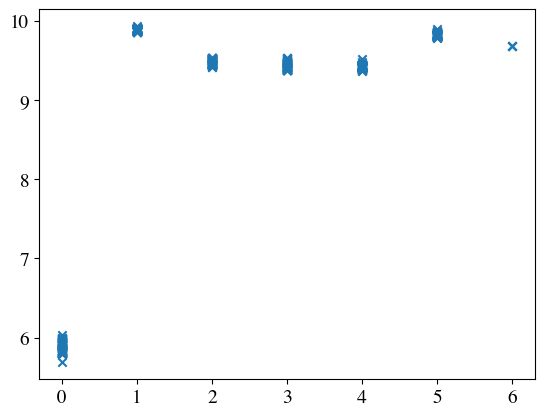

In [35]:
plt.scatter(data["jmp"][:500], np.asarray(data["pwr"][:500])*1000, marker="x")

In [36]:
jmp_set = set(data["jmp"])

jmps = sorted(list(jmp_set))
pwrs = [ np.average(np.asarray(data["pwr"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]
errs = [ np.sqrt(np.var(np.asarray(data["pwr"])[np.asarray(data["jmp"]) == jmp])) for jmp in jmps ]

x1s = np.array([ np.average(np.asarray(data["x1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][:25])
y1s = np.array([ np.average(np.asarray(data["y1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][:25])
x2s = np.array([ np.average(np.asarray(data["x2"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][:25])
y2s = np.array([ np.average(np.asarray(data["y2"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][:25])

In [37]:
import matplotlib
matplotlib.rcParams['font.family'] = ['Times', 'serif']
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.size'] = "14"

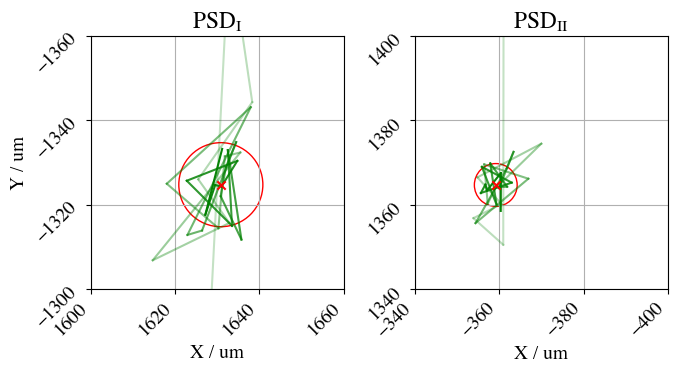

In [38]:
from matplotlib import patches

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

for i in range(1, len(x1s)):
    alpha = 0.8 / (len(x2s)) * i + 0.2
    ax1.plot(x1s[i-1:i+1]*5000, y1s[i-1:i+1]*5000, alpha=alpha, color="green")
    
x1_avg = np.average([ np.average(np.asarray(data["x1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][10:25])
y1_avg = np.average([ np.average(np.asarray(data["y1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][10:25])

x1_std = np.std([ np.average(np.asarray(data["x1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][10:25])
y1_std = np.std([ np.average(np.asarray(data["y1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][10:25])

ax1.scatter(x1_avg*5000, y1_avg*5000, alpha=alpha, color="red", marker="x", zorder=3)

circle1 = patches.Circle((x1_avg*5000, y1_avg*5000), radius=5000*np.sqrt(x1_std**2 + y1_std**2), color='red', fill=False)
ax1.add_patch(circle1)

ax1.set_xlim(1600, 1660)
ax1.set_ylim(-1300, -1360)
ax1.set_xticks(np.arange(1600, 1660 + 20, step=20))
ax1.set_yticks(np.arange(-1300, -1360 - 20, step=-20))
ax1.set_xticklabels(ax1.get_xticklabels(), ha="right", rotation=45)
ax1.set_yticklabels(ax1.get_yticklabels(), ha="right", rotation=45)
ax1.set_aspect('equal')

ax1.grid()

ax1.set_title(r"$\mathrm{PSD}_{\mathrm{I}}$")
ax1.set_xlabel("X / um")
ax1.set_ylabel("Y / um")

for i in range(1, len(x2s)):
    alpha = 0.8 / (len(x2s)) * i + 0.2
    ax2.plot(x2s[i-1:i+1]*5000, y2s[i-1:i+1]*5000, alpha=alpha, color="green")
    
x2_avg = np.average([ np.average(np.asarray(data["x2"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][10:25])
y2_avg = np.average([ np.average(np.asarray(data["y2"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][10:25])

x2_std = np.std([ np.average(np.asarray(data["x2"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][10:25])
y2_std = np.std([ np.average(np.asarray(data["y2"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][10:25])

ax2.scatter(x2_avg*5000, y2_avg*5000, alpha=alpha, color="red", marker="x", zorder=3)

circle1 = patches.Circle((x2_avg*5000, y2_avg*5000), radius=5000*np.sqrt(x2_std**2 + y2_std**2), color='red', fill=False)
ax2.add_patch(circle1)
    
ax2.set_xlim(-340, -400)
ax2.set_ylim(1340, 1400)
ax2.set_xticks(np.arange(-340, -400 - 20, step=-20))
ax2.set_yticks(np.arange(1340, 1400 + 20, step=20))
ax2.set_xticklabels(ax2.get_xticklabels(), ha="right", rotation=45)
ax2.set_yticklabels(ax2.get_yticklabels(), ha="right", rotation=45)
ax2.set_aspect('equal')

ax2.grid()

ax2.set_title(r"$\mathrm{PSD}_{\mathrm{II}}$")
ax2.set_xlabel("X / um")
#ax2.set_ylabel("Y / um")

fig.tight_layout()

fig.savefig("trajectory.pdf", format="pdf", dpi=300, bbox_inches='tight')

In [39]:
r1 = np.sqrt(x1_std**2 + y1_std**2)
r2 = np.sqrt(x2_std**2 + y2_std**2)
print(f"r1 radius: {r1*5000} um")
print(f"r2 radius: {r2*5000} um")

r1 radius: 9.948462138741046 um
r2 radius: 5.064782394175875 um


In [40]:
np.arctan((4e-3/2 + 4e-3/2) / 325)

1.2307692307070855e-05

Text(0, 0.5, 'Power / mW')

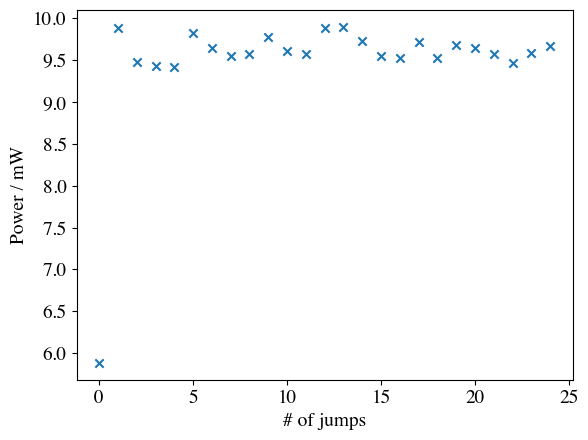

In [41]:
plt.scatter(jmps[:25], np.asarray(pwrs[:25])*1000, marker="x")
plt.xlabel("# of jumps")
plt.ylabel("Power / mW")

Text(0, 0.5, 'Power / mW')

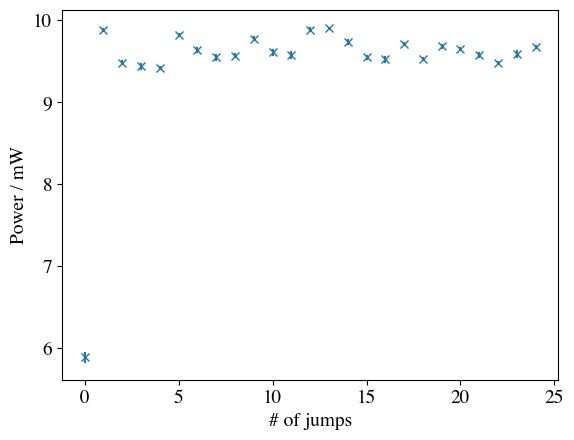

In [42]:
plt.errorbar(jmps[:25], np.asarray(pwrs[:25])*1000, yerr=np.asarray(errs[:25])*1000, fmt="x")
plt.xlabel("# of jumps")
plt.ylabel("Power / mW")

Text(0, 0.5, 'Power / mW')

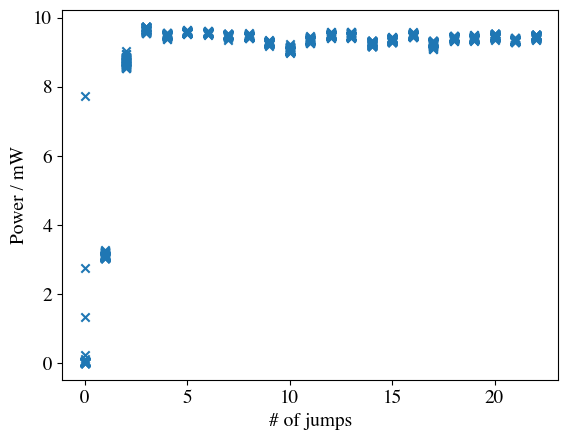

In [43]:
data = load_jump_data_file("2022-10-27T18_jmp1.txt")

plt.scatter(data["jmp"], np.asarray(data["pwr"])*1000, marker="x")
plt.xlabel("# of jumps")
plt.ylabel("Power / mW")

/Users/terrygeng/Library/Python/3.10/lib/python/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/terrygeng/Library/Python/3.10/lib/python/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(-0.26, -0.28)

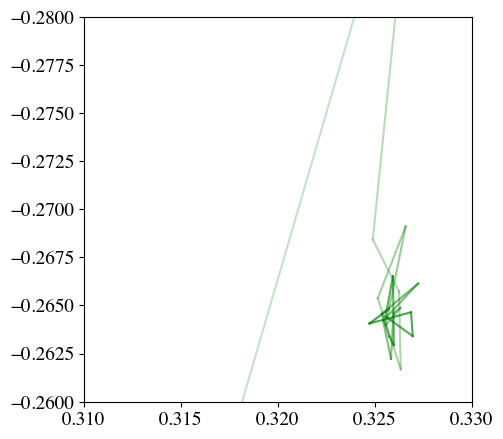

In [44]:
x1s = [ np.average(np.asarray(data["x1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]
y1s = [ np.average(np.asarray(data["y1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]

plt.figure(figsize=(5, 5))

for i in range(1, len(x1s)):
    alpha = 0.8 / (len(x1s)) * i + 0.2
    plt.plot(x1s[i-1:i+1], y1s[i-1:i+1], alpha=alpha, color="green")
plt.xlim(0.31, 0.33)
plt.ylim(-0.26, -0.28)

Text(0, 0.5, 'Power / mW')

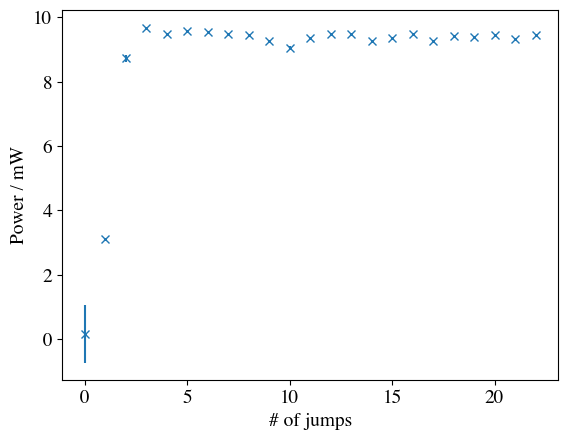

In [45]:
jmp_set = set(data["jmp"])

jmps = sorted(list(jmp_set))
pwrs = [ np.average(np.asarray(data["pwr"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]
errs = [ np.sqrt(np.var(np.asarray(data["pwr"])[np.asarray(data["jmp"]) == jmp])) for jmp in jmps ]

plt.errorbar(jmps[:25], np.asarray(pwrs[:25])*1000, yerr=np.asarray(errs[:25])*1000, fmt="x")
plt.xlabel("# of jumps")
plt.ylabel("Power / mW")

(0.0, 10.0)

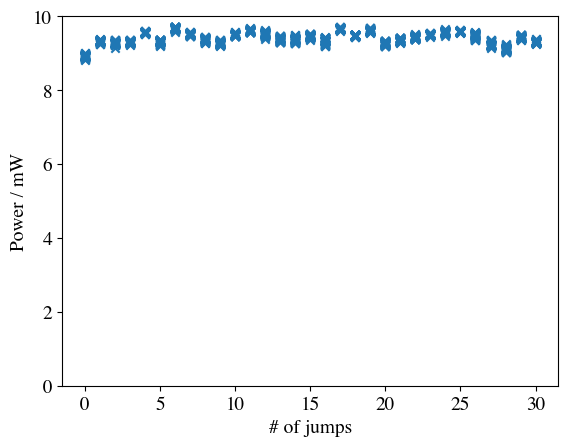

In [46]:
data = load_jump_data_file("2022-10-27T18_jmp2.txt")

plt.scatter(data["jmp"], np.asarray(data["pwr"])*1000, marker="x")
plt.xlabel("# of jumps")
plt.ylabel("Power / mW")
plt.ylim(0, 10)

(8.0, 10.0)

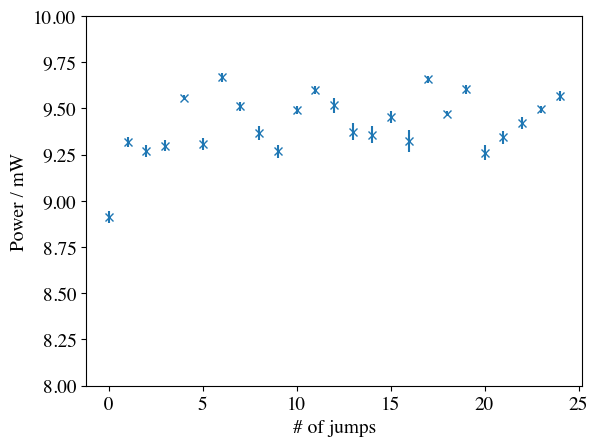

In [47]:
jmp_set = set(data["jmp"])

jmps = sorted(list(jmp_set))
pwrs = [ np.average(np.asarray(data["pwr"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]
errs = [ np.sqrt(np.var(np.asarray(data["pwr"])[np.asarray(data["jmp"]) == jmp])) for jmp in jmps ]

plt.errorbar(jmps[:25], np.asarray(pwrs[:25])*1000, yerr=np.asarray(errs[:25])*1000, fmt="x")
plt.xlabel("# of jumps")
plt.ylabel("Power / mW")
plt.ylim(8, 10)

(-0.26, -0.28)

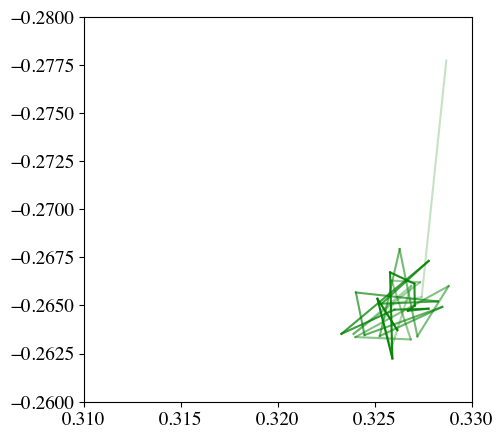

In [48]:
x1s = [ np.average(np.asarray(data["x1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]
y1s = [ np.average(np.asarray(data["y1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]

plt.figure(figsize=(5, 5))

for i in range(1, len(x1s)):
    alpha = 0.8 / (len(x1s)) * i + 0.2
    plt.plot(x1s[i-1:i+1], y1s[i-1:i+1], alpha=alpha, color="green")
plt.xlim(0.31, 0.33)
plt.ylim(-0.26, -0.28)

## Power stability

In [49]:
def load_power_data_file(file):
    with open(file, "r") as f:
        data = {
            "ts": [],
            "pwr": [],
            "p1_x1s": [],
            "p1_x2s": [],
            "p1_y1s": [],
            "p1_y2s": [],
            "p1_err_x1s": [],
            "p1_err_x2s": [],
            "p1_err_y1s": [],
            "p1_err_y2s": [],
            "p2_x1s": [],
            "p2_x2s": [],
            "p2_y1s": [],
            "p2_y2s": [],
            "p2_err_x1s": [],
            "p2_err_x2s": [],
            "p2_err_y1s": [],
            "p2_err_y2s": [],
            "x1": [],
            "y1": [],
            "x2": [],
            "y2": [],
            "err_x1": [],
            "err_y1": [],
            "err_x2": [],
            "err_y2": []
        }
        
        time1 = 0

        for line in f:
            _, _, _, pwr, r, time, x1, x2, y1, y2, err_x1, err_x2, err_y1, err_y2 = line.split()

            if r == "r1":
                time1 = int(time)
                data["ts"].append(datetime.fromtimestamp(int(time)))
                data["pwr"].append(float(pwr))
                data["p1_x1s"].append(int(x1))
                data["p1_x2s"].append(int(x2))
                data["p1_y1s"].append(int(y1))
                data["p1_y2s"].append(int(y2))
                data["p1_err_x1s"].append(int(err_x1))
                data["p1_err_x2s"].append(int(err_x2))
                data["p1_err_y1s"].append(int(err_y1))
                data["p1_err_y2s"].append(int(err_y2))
                
                x1_ = int(x1) - p1_x1_offset
                x2_ = int(x2) - p1_x2_offset
                y1_ = int(y1) - p1_y1_offset
                y2_ = int(y2) - p1_y2_offset
                
                x = (x1_ - x2_) / (x1_ + x2_)
                y = (y1_ - y2_) / (y1_ + y2_)
                
                err_x = quotient_err(x1_, x2_, int(err_x1), int(err_x2))
                err_y = quotient_err(y1_, y2_, int(err_y1), int(err_y2))
                
                data["x1"].append(x)
                data["y1"].append(y)
                data["err_x1"].append(err_x)
                data["err_y1"].append(err_y)
                
            elif r == "r2":
                data["p2_x1s"].append(int(x1))
                data["p2_x2s"].append(int(x2))
                data["p2_y1s"].append(int(y1))
                data["p2_y2s"].append(int(y2))
                data["p2_err_x1s"].append(int(err_x1))
                data["p2_err_x2s"].append(int(err_x2))
                data["p2_err_y1s"].append(int(err_y1))
                data["p2_err_y2s"].append(int(err_y2))
                
                x1_ = int(x1) - p2_x1_offset
                x2_ = int(x2) - p2_x2_offset
                y1_ = int(y1) - p2_y1_offset
                y2_ = int(y2) - p2_y2_offset
                
                x = (x1_ - x2_) / (x1_ + x2_)
                y = (y1_ - y2_) / (y1_ + y2_)
                
                err_x = quotient_err(x1_, x2_, int(err_x1), int(err_x2))
                err_y = quotient_err(y1_, y2_, int(err_y1), int(err_y2))
                
                data["x2"].append(x)
                data["y2"].append(y)
                data["err_x2"].append(err_x)
                data["err_y2"].append(err_y)
        
        for key in data.keys():
            data[key] = np.array(data[key])
            
        return data

In [50]:
data = load_power_data_file("2022-10-27T18_pwr.txt")

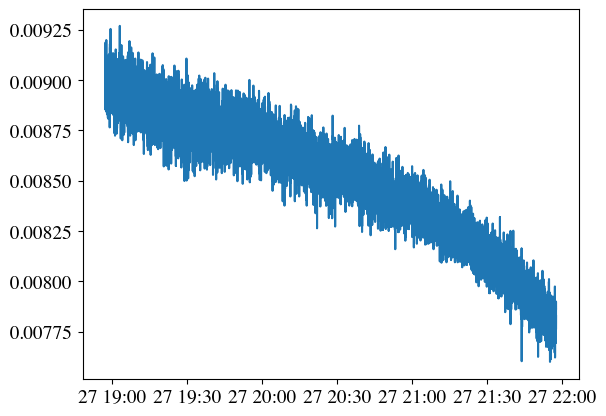

In [51]:
plt.plot(data["ts"], data["pwr"])

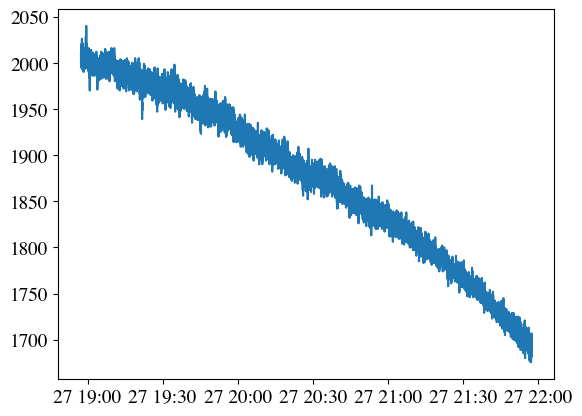

In [52]:
plt.plot(data["ts"], np.asarray(data["p1_x1s"]) + np.asarray(data["p1_x2s"]))

Text(0, 0.5, 'Power / mW')

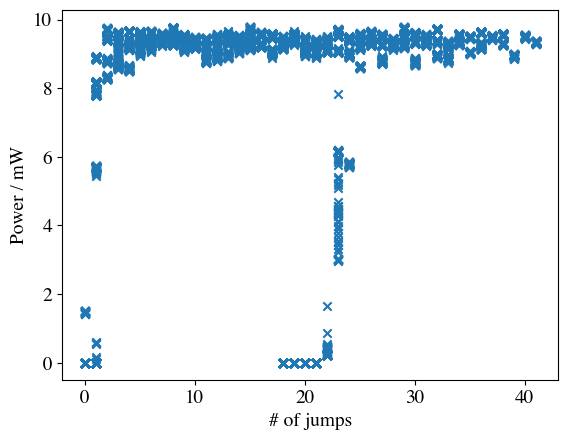

In [53]:
data = load_jump_data_file("2022-11-01T19_jmp.txt")

plt.scatter(data["jmp"], np.asarray(data["pwr"])*1000, marker="x")
plt.xlabel("# of jumps")
plt.ylabel("Power / mW")

In [54]:
jmp_set = set(data["jmp"])

jmps = sorted(list(jmp_set))
pwrs = [ np.average(np.asarray(data["pwr"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]
errs = [ np.sqrt(np.var(np.asarray(data["pwr"])[np.asarray(data["jmp"]) == jmp])) for jmp in jmps ]

x1s = [ np.average(np.asarray(data["x1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][:25]
y1s = [ np.average(np.asarray(data["y1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][:25]

x2s = [ np.average(np.asarray(data["x2"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][:25]
y2s = [ np.average(np.asarray(data["y2"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][:25]
x1s = [ np.average(np.asarray(data["x1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]
y1s = [ np.average(np.asarray(data["y1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]

plt.figure(figsize=(5, 5))

for i in range(1, len(x1s)):
    alpha = 0.8 / (len(x1s)) * i + 0.2
    plt.plot(x1s[i-1:i+1], y1s[i-1:i+1], alpha=alpha, color="green")
plt.xlim(0.31, 0.33)
plt.ylim(-0.26, -0.28)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 13840 but corresponding boolean dimension is 13841

In [ ]:
data = load_jump_data_file("2022-11-01T19_jmp1.txt")

plt.scatter(data["jmp"], np.asarray(data["pwr"])*1000, marker="x")
plt.xlabel("# of jumps")
plt.ylabel("Power / mW")

In [ ]:
jmp_set = set(data["jmp"])

jmps = sorted(list(jmp_set))
pwrs = [ np.average(np.asarray(data["pwr"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]
errs = [ np.sqrt(np.var(np.asarray(data["pwr"])[np.asarray(data["jmp"]) == jmp])) for jmp in jmps ]

x1s = [ np.average(np.asarray(data["x1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][:25]
y1s = [ np.average(np.asarray(data["y1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][:25]

x2s = [ np.average(np.asarray(data["x2"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][:25]
y2s = [ np.average(np.asarray(data["y2"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][:25]
x1s = [ np.average(np.asarray(data["x1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]
y1s = [ np.average(np.asarray(data["y1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]

plt.figure(figsize=(5, 5))

for i in range(1, len(x1s)):
    alpha = 0.8 / (len(x1s)) * i + 0.2
    plt.plot(x1s[i-1:i+1], y1s[i-1:i+1], alpha=alpha, color="green")
plt.xlim(0.31, 0.33)
plt.ylim(-0.26, -0.28)

Text(0, 0.5, 'Power / mW')

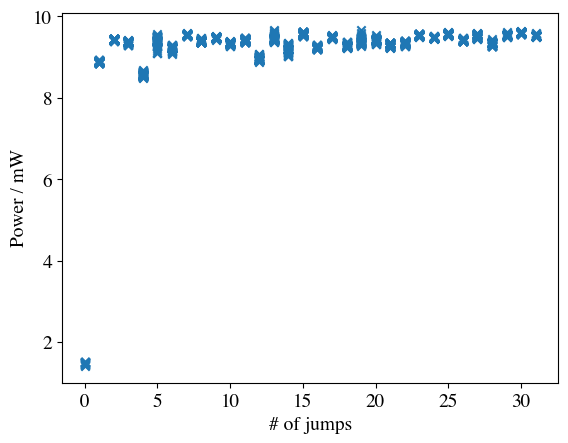

In [55]:
data = load_jump_data_file("2022-11-01T19_jmp3.txt")

plt.scatter(data["jmp"], np.asarray(data["pwr"])*1000, marker="x")
plt.xlabel("# of jumps")
plt.ylabel("Power / mW")

radius: 9.565328315392378 um


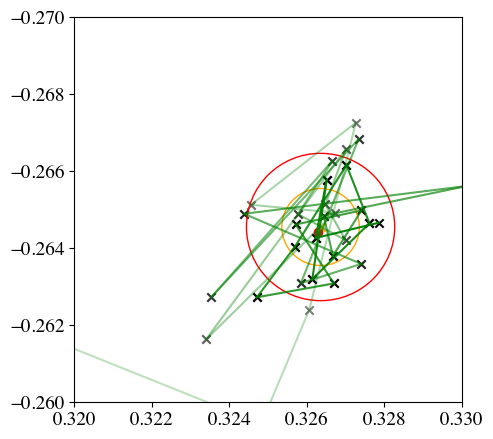

In [56]:
from matplotlib import patches

jmp_set = set(data["jmp"])

jmps = sorted(list(jmp_set))
pwrs = [ np.average(np.asarray(data["pwr"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]
errs = [ np.sqrt(np.var(np.asarray(data["pwr"])[np.asarray(data["jmp"]) == jmp])) for jmp in jmps ]

x2s = [ np.average(np.asarray(data["x2"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]
y2s = [ np.average(np.asarray(data["y2"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]

x1s = [ np.average(np.asarray(data["x1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]
y1s = [ np.average(np.asarray(data["y1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]



dest_p1 = (0.3263, -0.2644)
#dest_p2 = (-0.0718, 0.2730)

plt.figure(figsize=(5, 5))

for i in range(1, len(x1s)):
    alpha = 0.8 / (len(x1s)) * i + 0.2
    plt.plot(x1s[i-1:i+1], y1s[i-1:i+1], alpha=alpha, color="green")
    plt.scatter(x1s[i-1:i+1], y1s[i-1:i+1], alpha=alpha, color="black", marker="x")

plt.scatter(dest_p1[0], dest_p1[1], alpha=alpha, color="red")

x1_avg = np.average([ np.average(np.asarray(data["x1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][3:])
y1_avg = np.average([ np.average(np.asarray(data["y1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][3:])

x1_std = np.std([ np.average(np.asarray(data["x1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][3:])
y1_std = np.std([ np.average(np.asarray(data["y1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ][3:])

plt.scatter(x1_avg, y1_avg, alpha=alpha, color="orange", marker="x")

circle1 = patches.Circle((x1_avg, y1_avg), radius=np.sqrt(x1_std**2 + y1_std**2), color='red', fill=False)
plt.gca().add_patch(circle1)

circle2 = patches.Circle((x1_avg, y1_avg), radius=1e-3, color='orange', fill=False)
plt.gca().add_patch(circle2)

plt.xlim(0.32, 0.33)
plt.ylim(-0.26, -0.27)

r = np.sqrt(x1_std**2 + y1_std**2)
print(f"radius: {r*5000} um")

Text(0, 0.5, 'Power / mW')

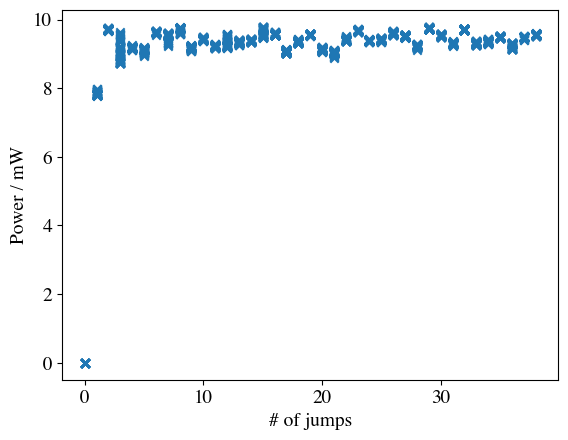

In [57]:
data = load_jump_data_file("2022-11-01T19_jmp4.txt")

plt.scatter(data["jmp"], np.asarray(data["pwr"])*1000, marker="x")
plt.xlabel("# of jumps")
plt.ylabel("Power / mW")

(-0.25, -0.27)

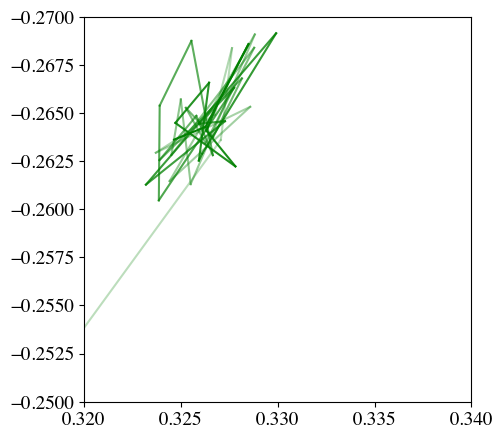

In [58]:
jmp_set = set(data["jmp"])

jmps = sorted(list(jmp_set))
pwrs = [ np.average(np.asarray(data["pwr"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]
errs = [ np.sqrt(np.var(np.asarray(data["pwr"])[np.asarray(data["jmp"]) == jmp])) for jmp in jmps ]

x2s = [ np.average(np.asarray(data["x2"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]
y2s = [ np.average(np.asarray(data["y2"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]
x1s = [ np.average(np.asarray(data["x1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]
y1s = [ np.average(np.asarray(data["y1"])[np.asarray(data["jmp"]) == jmp]) for jmp in jmps ]

plt.figure(figsize=(5, 5))

for i in range(1, len(x1s)):
    alpha = 0.8 / (len(x1s)) * i + 0.2
    plt.plot(x1s[i-1:i+1], y1s[i-1:i+1], alpha=alpha, color="green")
plt.xlim(0.32, 0.34)
plt.ylim(-0.25, -0.27)